### IMPORTS AND SETUP

In [52]:
# Basic imports and setup
import numpy as np
import pandas as pd
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', None)
import geopandas as gpd
import shapely.wkt
import os, warnings
import logging
import math
from scipy import spatial
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from scipy.stats import yeojohnson
from sklearn.ensemble import IsolationForest
import optuna
from optuna.samplers import TPESampler
import datetime
import sys

# ML libraries
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor, Pool

from sklearn.ensemble import (
    RandomForestRegressor,
    ExtraTreesRegressor,
    HistGradientBoostingRegressor,
    GradientBoostingRegressor,
    VotingRegressor
)
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, KFold, cross_val_score, GroupKFold, train_test_split
from sklearn.linear_model import BayesianRidge, ElasticNet, Ridge, Lasso, LinearRegression, HuberRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, WhiteKernel, RationalQuadratic, ExpSineSquared
from sklearn.cluster import DBSCAN
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.base import clone, BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.feature_selection import SelectFromModel
from joblib import dump, Parallel, delayed
from scipy.optimize import minimize

# Geospatial libraries
from shapely.geometry import Point, Polygon, MultiPolygon, MultiPoint
from shapely.ops import nearest_points
import rioxarray as rxr
import rasterio

# Visualization
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import random

# Warning handling
logging.basicConfig(filename='warnings.log', level=logging.DEBUG)

def custom_warning_handler(message, category, filename, lineno, file=None, line=None):
    logging.debug(f'{category.__name__}: {message} in {filename}:{lineno}')
warnings.showwarning = custom_warning_handler

# Constants
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
SHOW_PLOTS = True  # Set to False to skip plots

print("Python executable:", sys.executable)

Python executable: C:\workspace\python\ai-challenge-2025\.venv\Scripts\python.exe


### FEATURE TOGGLES

In [8]:
FEATURE_FLAGS = {
    # Building coverage at multiple scales
    "building_cov_250m": True,
    "building_cov_500m": True,
    "building_cov_750m": True,
    "building_cov_1000m": True,
    "building_cov_std": True,  # Standard deviation across different radii

    # Distance to water and parks with decay transformations
    "distance_water": True,
    "distance_water_exp": True,
    "distance_parks": True,
    "distance_parks_exp": True,
    "distance_water_quad": True,  # Quadratic decay - Enabled for v26
    "distance_parks_quad": True,  # Quadratic decay - Enabled for v26

    # Street tree coverage at multiple scales
    "street_tree_cov_250m": True,
    "street_tree_cov_500m": True,
    "street_tree_cov_750m": True,
    "street_tree_cov_1000m": True,

    # Distance to subway and urban centers
    "dist_to_closest_subway_station": True,
    "dist_to_closest_subway_exp": True,
    "dist_to_closest_urban_centre": True,
    "dist_to_closest_urban_centre_exp": True,
    "urban_cluster_id": True,
    
    # Raster-based features
    "lst_value": True,
    "ndvi_value": True,
    "ndbi_value": True,
    "ndwi_value": True,
    "evi_value": True,
    "mndwi_value": True,
    
    # Interaction features - Added more for v26
    "bldg_lst_interaction": True,
    "ndvi_bldg_interaction": True,
    "water_park_interaction": True,
    "lst_ndvi_interaction": True,
    "advanced_interactions": True,  # NEW for v26: Additional complex interactions
    
    # Complex features - Enabled more for v26
    "building_density_gradient": True,
    "urban_canyon_effect": True,
    "distance_to_closest_water_park": True,
    "neighborhood_lst_anomaly": True,
    "micro_climate_zone": True,

    # PLUTO data features
    "map_pluto_data": True,
}

# Define the list of PLUTO columns to extract
pluto_columns = [
    "NumFloors", "NumBldgs", "UnitsRes", "UnitsTotal", 
    "LotArea", "BldgArea", "ComArea", "ResArea", "FactryArea",
    "AssessLand", "AssessTot", "ExemptTot",
    "BuiltFAR", "ResidFAR", "CommFAR", "FacilFAR",
    "YearBuilt", #"YearAlter1", "YearAlter2", "SPDist1"
    "LandUse", "BldgClass", #"Borough", "ZoneDist1", "Overlay1", 
]

# Define column types for PLUTO data
col_types = {
    "NumFloors": "numerical",
    "LotArea": "numerical",
    "BuiltFAR": "numerical",
    "YearBuilt": "numerical",
    "Borough": "categorical",
    "NumBldgs": "numerical",
    "UnitsRes": "numerical",
    "UnitsTotal": "numerical",
    "BldgArea": "numerical",
    "ComArea": "numerical",
    "ResArea": "numerical",
    "FactryArea": "numerical",
    "AssessLand": "numerical",
    "AssessTot": "numerical",
    "ExemptTot": "numerical",
    "ResidFAR": "numerical",
    "CommFAR": "numerical",
    "FacilFAR": "numerical",
    "ZoneDist1": "categorical",
    "Overlay1": "categorical",
    "LandUse": "categorical",
    "BldgClass": "categorical",
}

# Automatically divide the active columns based on the mapping
num_cols = [col for col in pluto_columns if col_types.get(col) == "numerical"]
cat_cols = [col for col in pluto_columns if col_types.get(col) == "categorical"]

print("Numerical Columns:", num_cols)
print("Categorical Columns:", cat_cols)

Numerical Columns: ['NumFloors', 'NumBldgs', 'UnitsRes', 'UnitsTotal', 'LotArea', 'BldgArea', 'ComArea', 'ResArea', 'FactryArea', 'AssessLand', 'AssessTot', 'ExemptTot', 'BuiltFAR', 'ResidFAR', 'CommFAR', 'FacilFAR', 'YearBuilt']
Categorical Columns: ['LandUse', 'BldgClass']


### HELPER FUNCTIONS

In [38]:
def exponential_decay(distance, scale=500):
    """Transform distance with exponential decay function"""
    return np.exp(-distance / scale)

def quadratic_decay(distance, scale=500):
    """Transform distance with quadratic decay function"""
    return 1 / (1 + (distance/scale)**2)

def coverage_fraction(geom, polygon_gdf, radius=50):
    """Calculate the fraction of area covered by polygons within a buffer"""
    buffer_poly = geom.buffer(radius)
    clipped = gpd.clip(polygon_gdf, buffer_poly)
    area_polygons = clipped.geometry.area.sum()
    area_buffer = buffer_poly.area
    return area_polygons / area_buffer if area_buffer > 0 else 0

def coverage_std_multi_radius(geom, polygon_gdf, radii=[100, 250, 500, 750]):
    """Calculate standard deviation of coverage at different radii"""
    coverages = []
    for radius in radii:
        coverages.append(coverage_fraction(geom, polygon_gdf, radius))
    return np.std(coverages)

def building_coverage_fraction(geom, building_gdf, radius=50):
    """Calculate fraction of area covered by buildings within a buffer"""
    return coverage_fraction(geom, building_gdf, radius)

def distance_to_polygons(geom, poly_gdf):
    """Calculate minimum distance to any polygon in a GeoDataFrame"""
    dists = poly_gdf.geometry.distance(geom)
    return dists.min() if len(dists) > 0 else np.nan

def extract_raster_value(geom, raster, band_index=1, method="nearest"):
    """Extract value from raster at a point with fallback for edge cases"""
    try:
        x, y = geom.x, geom.y
        val = raster.sel(x=x, y=y, band=band_index, method=method).values
        return float(val)
    except (ValueError, IndexError) as e:
        # Fallback: Try to sample nearby values if exact point fails
        try:
            x, y = geom.x, geom.y
            buffer_size = 10  # Small buffer
            # Get average from small buffer area
            vals = []
            for dx in [-buffer_size, 0, buffer_size]:
                for dy in [-buffer_size, 0, buffer_size]:
                    try:
                        v = raster.sel(x=x+dx, y=y+dy, band=band_index, method=method).values
                        vals.append(float(v))
                    except:
                        pass
            if vals:
                return np.mean(vals)
            return np.nan
        except:
            return np.nan

def find_nearest_building_cluster(pt_geom, gdf_bldg):
    """Find the nearest building cluster to a point"""
    distances = gdf_bldg["centroid"].distance(pt_geom)
    if len(distances) == 0:
        return None
    idx_min = distances.idxmin()
    return gdf_bldg.loc[idx_min, "bldg_cluster"]

def nearest_cluster_centroid_label(pt_geom, cluster_centroids):
    """Get label of the nearest cluster centroid to a point"""
    px, py = pt_geom.x, pt_geom.y
    best_label = None
    best_dist = float("inf")
    for (c_label, (cx, cy)) in cluster_centroids:
        dist_ = math.hypot(cx - px, cy - py)
        if dist_ < best_dist:
            best_dist = dist_
            best_label = c_label
    return best_label

def euclidean_distance(x1, y1, x2, y2):
    """Calculate Euclidean distance between two points"""
    return math.hypot(x2 - x1, y2 - y1)

def dist_to_closest_cluster_centroid_feature(geom, cluster_centroids):
    """Calculate distance to closest cluster centroid"""
    px, py = geom.x, geom.y
    dmin = float("inf")
    for (lbl, (cx, cy)) in cluster_centroids:
        d = euclidean_distance(px, py, cx, cy)
        if d < dmin:
            dmin = d
    return dmin

def run_dbscan_on_buildings(gdf_buildings, eps_m=400, min_samples=10, N_LARGEST=3):
    """Run DBSCAN clustering on building centroids"""
    if "centroid" not in gdf_buildings.columns:
        gdf_buildings["centroid"] = gdf_buildings.geometry.centroid
    
    coords_bldg = np.column_stack([gdf_buildings["centroid"].x, gdf_buildings["centroid"].y])
    
    db = DBSCAN(eps=eps_m, min_samples=min_samples).fit(coords_bldg)
    labels_bldg = db.labels_
    gdf_buildings["bldg_cluster"] = labels_bldg
    
    valid_mask = (labels_bldg >= 0)
    unique_labels, counts = np.unique(labels_bldg[valid_mask], return_counts=True)
    
    sorted_idx = np.argsort(-counts)
    sorted_labels = unique_labels[sorted_idx]
    sorted_counts = counts[sorted_idx]
    
    top_clusters = sorted_labels[:N_LARGEST]
    
    cluster_centroids = []
    for clabel in top_clusters:
        cl_mask = (gdf_buildings["bldg_cluster"] == clabel)
        cluster_coords = coords_bldg[cl_mask]
        if len(cluster_coords) > 0:
            mp = MultiPoint(cluster_coords)
            c_centroid = mp.centroid
            cluster_centroids.append((clabel, (c_centroid.x, c_centroid.y)))
    
    return gdf_buildings, cluster_centroids, top_clusters

def get_pluto_features(geom, gdf, pluto_columns, initial_buffer=1.0, max_buffer=256.0):
    """
    For a given point geometry, first try to find a polygon in 'gdf' (e.g. your enriched gdf_buildings)
    that contains the point. If none is found, gradually increase the buffer (doubling each time)
    until a candidate is found or until max_buffer is reached.
    Parameters:
      - geom: a shapely geometry (typically a Point).
      - gdf: a GeoDataFrame with the PLUTO (or enriched) features.
      - pluto_columns: list of column names to extract.
      - initial_buffer: starting buffer distance in the CRS units (e.g., meters).
      - max_buffer: maximum buffer distance to try.
    Returns:
      A dictionary mapping each column in pluto_columns to its value in the found polygon;
      if no polygon is found, returns a dictionary with np.nan for each column.
    """
    # First try an exact "within" query (no buffer)
    candidate_idx = list(gdf.sindex.query(geom, predicate="within"))
    buffer_distance = initial_buffer
    # If no candidate is found, gradually increase the search area.
    while not candidate_idx and buffer_distance <= max_buffer:
        # Use a buffer around the point and look for intersections.
        candidate_idx = list(gdf.sindex.query(geom.buffer(buffer_distance), predicate="intersects"))
        buffer_distance *= 2  # Double the buffer and try again.
    if not candidate_idx:
        # If still nothing is found, return NaNs for all the requested columns.
        return {col: np.nan for col in pluto_columns}
    # If multiple candidates are found, select the first candidate.
    best_match = gdf.iloc[candidate_idx[0]]
    return best_match[pluto_columns].to_dict()

def aggregate_pluto_numerics_in_radius(geom, pluto_gdf, numeric_cols, radius=500):
    """
    For each numeric column in 'numeric_cols', compute the average
    among PLUTO polygons that fall inside a 'radius' meter buffer 
    around 'geom'. If no polygons are found, return np.nan for each col.
    """
    # 1. Create buffer
    buffer_poly = geom.buffer(radius)
    # 2. Clip pluto_gdf with that buffer
    #    (So we only get polygons that lie in that buffer)
    clipped_pluto = gpd.clip(pluto_gdf, buffer_poly)
    # If no polygons found => return nan
    if clipped_pluto.empty:
        return {col: np.nan for col in numeric_cols}
    # 3. For each numeric col => compute the mean
    result = {}
    for col in numeric_cols:
        if col in clipped_pluto.columns:
            # Area weighted average
            area = clipped_pluto.geometry.area
            col_mean = (clipped_pluto[col] * area).sum() / area.sum()
            result[col] = col_mean
        else:
            result[col] = np.nan
    return result

# New for v26: Enhanced interaction features
def create_interaction_features(df):
    """Create interaction features that capture combined effects"""
    # Save a copy of the original dataframe
    result_df = df.copy()
    
    # Original interactions
    if "building_cov_500m" in result_df.columns and "lst_value" in result_df.columns:
        result_df["bldg_lst_interaction"] = result_df["building_cov_500m"] * result_df["lst_value"]
    
    if "building_cov_500m" in result_df.columns and "ndvi_value" in result_df.columns:
        result_df["ndvi_bldg_interaction"] = result_df["ndvi_value"] * (1 - result_df["building_cov_500m"])
    
    if "distance_water_exp" in result_df.columns and "distance_parks_exp" in result_df.columns:
        result_df["water_park_interaction"] = result_df["distance_water_exp"] * result_df["distance_parks_exp"]
    
    # Interactions
    if "lst_value" in result_df.columns and "ndvi_value" in result_df.columns:
        result_df["lst_ndvi_interaction"] = result_df["lst_value"] * result_df["ndvi_value"]
    
    # Urban canyon effect (high buildings, low sky view)
    if "building_cov_500m" in result_df.columns and "building_cov_250m" in result_df.columns:
        result_df["urban_canyon_effect"] = result_df["building_cov_250m"] / (result_df["building_cov_500m"] + 0.01)
    
    # Building density gradient (measure of how quickly building density changes with distance)
    if all(col in result_df.columns for col in ["building_cov_250m", "building_cov_500m", "building_cov_750m"]):
        result_df["building_density_gradient"] = (result_df["building_cov_250m"] - result_df["building_cov_750m"]) / (500)
    
    # Exponential and quadratic transformations for distances
    if "distance_water" in result_df.columns:
        result_df["distance_water_quad"] = quadratic_decay(result_df["distance_water"], scale=500)
        
    if "distance_parks" in result_df.columns:
        result_df["distance_parks_quad"] = quadratic_decay(result_df["distance_parks"], scale=500)
    
    # Minimum distance to either water or park (closest green/blue space)
    if "distance_water" in result_df.columns and "distance_parks" in result_df.columns:
        result_df["distance_to_closest_water_park"] = result_df[["distance_water", "distance_parks"]].min(axis=1)
    
    # Polynomial features for LST (which is likely the most important predictor)
    if "lst_value" in result_df.columns:
        result_df["lst_value_squared"] = result_df["lst_value"] ** 2
        result_df["lst_value_cubed"] = result_df["lst_value"] ** 3
    
    # NEW FOR v26: Advanced feature interactions
    if FEATURE_FLAGS["advanced_interactions"]:
        # Advanced LST interactions with key environment variables
        if "lst_value" in result_df.columns:
            important_features = ["ndvi_value", "building_cov_500m", "distance_water_exp", 
                                 "distance_parks_exp", "street_tree_cov_500m"]
            
            for feat in important_features:
                if feat in result_df.columns:
                    # Create multiplicative interaction
                    result_df[f"lst_{feat}_interaction"] = result_df["lst_value"] * result_df[feat]
                    # Create ratio feature
                    result_df[f"lst_{feat}_ratio"] = result_df["lst_value"] / (result_df[feat] + 0.001)
            
            # Add neighborhood_lst_anomaly interactions if available
            if "neighborhood_lst_anomaly" in result_df.columns:
                result_df["lst_anomaly_interaction"] = result_df["lst_value"] * result_df["neighborhood_lst_anomaly"]
                
            # Second-order polynomial interactions between key features
            if "ndvi_value" in result_df.columns:
                result_df["lst_ndvi_squared"] = result_df["lst_value"] * result_df["ndvi_value"]**2
                
        # Distance ratio features
        if all(x in result_df.columns for x in ["distance_water", "distance_parks"]):
            result_df["water_park_distance_ratio"] = result_df["distance_water"] / (result_df["distance_parks"] + 0.001)
        
        # Composite urban heat features
        if all(x in result_df.columns for x in ["building_cov_500m", "street_tree_cov_500m", "lst_value"]):
            result_df["urban_heat_index"] = (result_df["building_cov_500m"] * result_df["lst_value"]) / (result_df["street_tree_cov_500m"] + 0.001)
        
        # Urban-to-green space transition features
        if all(x in result_df.columns for x in ["building_cov_500m", "distance_parks_exp"]):
            result_df["urban_green_transition"] = result_df["building_cov_500m"] * result_df["distance_parks_exp"]
            
        # Combined LST effect with building gradient
        if all(x in result_df.columns for x in ["lst_value", "building_density_gradient"]):
            result_df["lst_bldg_gradient"] = result_df["lst_value"] * result_df["building_density_gradient"]
        
    return result_df

def extract_features(gdf, features_dict=None, 
                     gdf_buildings=None, gdf_water=None, gdf_parks=None,
                     gdf_trees_poly=None, gdf_stations=None,
                     lst_raster_2263=None, indices_raster_2263=None,
                     gdf_pluto=None, pluto_features_dict=None):
    """
    Extract features for points in a GeoDataFrame
    
    This function extracts various geographical and environmental features
    for each point in the provided GeoDataFrame.
    """
    if features_dict is None:
        features_dict = {key: [] for key, val in FEATURE_FLAGS.items() if val and key != "map_pluto_data" and key != "advanced_interactions"}
    
    # Initialize PLUTO features dictionary if needed
    if FEATURE_FLAGS["map_pluto_data"] and pluto_features_dict is None:
        pluto_features_dict = {col: [] for col in pluto_columns}
    
    total_rows = len(gdf)
    print(f"Extracting features for {total_rows} points...")
    
    for i, row in gdf.iterrows():
        if i % 500 == 0:
            percent_done = (i / total_rows) * 100
            print(f"  -> {percent_done:.2f}% done")
        
        geom = row.geometry

        # Building coverage at multiple scales
        if FEATURE_FLAGS["building_cov_250m"] and gdf_buildings is not None:
            b250 = building_coverage_fraction(geom, gdf_buildings, 250)
            features_dict["building_cov_250m"].append(b250)
            
        if FEATURE_FLAGS["building_cov_500m"] and gdf_buildings is not None:
            b500 = building_coverage_fraction(geom, gdf_buildings, 500)
            features_dict["building_cov_500m"].append(b500)
            
        if FEATURE_FLAGS["building_cov_750m"] and gdf_buildings is not None:
            b750 = building_coverage_fraction(geom, gdf_buildings, 750)
            features_dict["building_cov_750m"].append(b750)

        if FEATURE_FLAGS["building_cov_1000m"] and gdf_buildings is not None:
            b1000 = building_coverage_fraction(geom, gdf_buildings, 1000)
            features_dict["building_cov_1000m"].append(b1000)
            
        if FEATURE_FLAGS["building_cov_std"] and gdf_buildings is not None:
            bstd = coverage_std_multi_radius(geom, gdf_buildings, [100, 250, 500, 750])
            features_dict["building_cov_std"].append(bstd)

        # Distance to water with exponential decay
        if FEATURE_FLAGS["distance_water"] and gdf_water is not None:
            dist_w = distance_to_polygons(geom, gdf_water)
            features_dict["distance_water"].append(dist_w)
            
            if FEATURE_FLAGS["distance_water_exp"]:
                dist_w_exp = exponential_decay(dist_w, scale=500)
                features_dict["distance_water_exp"].append(dist_w_exp)

        # Distance to parks with exponential decay
        if FEATURE_FLAGS["distance_parks"] and gdf_parks is not None:
            dist_p = distance_to_polygons(geom, gdf_parks)
            features_dict["distance_parks"].append(dist_p)
            
            if FEATURE_FLAGS["distance_parks_exp"]:
                dist_p_exp = exponential_decay(dist_p, scale=500)
                features_dict["distance_parks_exp"].append(dist_p_exp)

        # Street tree coverage at multiple scales
        if FEATURE_FLAGS["street_tree_cov_250m"] and gdf_trees_poly is not None:
            tree_250 = coverage_fraction(geom, gdf_trees_poly, 250)
            features_dict["street_tree_cov_250m"].append(tree_250)
            
        if FEATURE_FLAGS["street_tree_cov_500m"] and gdf_trees_poly is not None:
            tree_500 = coverage_fraction(geom, gdf_trees_poly, 500)
            features_dict["street_tree_cov_500m"].append(tree_500)
            
        if FEATURE_FLAGS["street_tree_cov_750m"] and gdf_trees_poly is not None:
            tree_750 = coverage_fraction(geom, gdf_trees_poly, 750)
            features_dict["street_tree_cov_750m"].append(tree_750)

        if FEATURE_FLAGS["street_tree_cov_1000m"] and gdf_trees_poly is not None:
            tree_1000 = coverage_fraction(geom, gdf_trees_poly, 1000)
            features_dict["street_tree_cov_1000m"].append(tree_1000)

        # Distance to subway
        if FEATURE_FLAGS["dist_to_closest_subway_station"] and gdf_stations is not None:
            dists_subway = gdf_stations.geometry.distance(geom)
            dist_sub = dists_subway.min() if len(dists_subway) > 0 else 0
            features_dict["dist_to_closest_subway_station"].append(dist_sub)
            
            if FEATURE_FLAGS["dist_to_closest_subway_exp"]:
                dist_sub_exp = exponential_decay(dist_sub, scale=800)
                features_dict["dist_to_closest_subway_exp"].append(dist_sub_exp)

        # Raster-based features
        if FEATURE_FLAGS["lst_value"] and lst_raster_2263 is not None:
            lst_val = extract_raster_value(geom, lst_raster_2263, band_index=1)
            features_dict["lst_value"].append(lst_val)

        if FEATURE_FLAGS["ndvi_value"] and indices_raster_2263 is not None:
            ndvi_val = extract_raster_value(geom, indices_raster_2263, band_index=1)
            features_dict["ndvi_value"].append(ndvi_val)

        if FEATURE_FLAGS["ndbi_value"] and indices_raster_2263 is not None:
            ndbi_val = extract_raster_value(geom, indices_raster_2263, band_index=2)
            features_dict["ndbi_value"].append(ndbi_val)

        if FEATURE_FLAGS["ndwi_value"] and indices_raster_2263 is not None:
            ndwi_val = extract_raster_value(geom, indices_raster_2263, band_index=3)
            features_dict["ndwi_value"].append(ndwi_val)

        if FEATURE_FLAGS["evi_value"] and indices_raster_2263 is not None:
            evi_value = extract_raster_value(geom, indices_raster_2263, band_index=4)
            features_dict["evi_value"].append(evi_value)
            
        if FEATURE_FLAGS["mndwi_value"] and indices_raster_2263 is not None:
            mndwi_value = extract_raster_value(geom, indices_raster_2263, band_index=5)
            features_dict["mndwi_value"].append(mndwi_value)

        # urban clusters
        if FEATURE_FLAGS["urban_cluster_id"] and cluster_centroids is not None:
            c_str = nearest_cluster_centroid_label(geom, cluster_centroids)
            if c_str is not None:
                c_str = f"N{c_str}"
            else:
                c_str = "other"
            features_dict["urban_cluster_id"].append(c_str)
        
        if FEATURE_FLAGS["dist_to_closest_urban_centre"] and cluster_centroids is not None:
            dmin = dist_to_closest_cluster_centroid_feature(geom, cluster_centroids)
            features_dict["dist_to_closest_urban_centre"].append(dmin)

            if FEATURE_FLAGS["dist_to_closest_urban_centre_exp"]:
                dmin_exp = exponential_decay(dmin, scale=800)
                features_dict["dist_to_closest_urban_centre_exp"].append(dmin_exp)
        
        # Extract PLUTO features
        if FEATURE_FLAGS["map_pluto_data"] and gdf_pluto is not None:
            # 1) For numeric columns => do radius aggregator
            radius = 500
            numeric_agg_vals = aggregate_pluto_numerics_in_radius(geom, gdf_pluto, num_cols, radius=radius)
            
            # 2) For categorical columns => use get_pluto_features
            cat_feats = get_pluto_features(geom, gdf_pluto, cat_cols)
            
            # 3) Store them in pluto_features_dict
            for col in num_cols:
                pluto_features_dict[col].append(numeric_agg_vals.get(col, np.nan))
            for col in cat_cols:
                pluto_features_dict[col].append(cat_feats.get(col, np.nan))
            
    print("100.00% done")
    return features_dict, pluto_features_dict

def extract_advanced_features(gdf, features_dict=None,
                              gdf_buildings=None, gdf_water=None, gdf_parks=None,
                              gdf_trees_poly=None, gdf_stations=None,
                              lst_raster_2263=None, indices_raster_2263=None,
                              gdf_pluto=None, pluto_features_dict=None):
    """
    Extract advanced features including neighborhood analysis
    """
    if features_dict is None:
        features_dict = {key: [] for key, val in FEATURE_FLAGS.items() if val and key != "map_pluto_data" and key != "advanced_interactions"}
    
    # Initialize PLUTO features dictionary if needed
    if FEATURE_FLAGS["map_pluto_data"] and pluto_features_dict is None:
        pluto_features_dict = {col: [] for col in pluto_columns}
    
    total_rows = len(gdf)
    print(f"Extracting advanced features for {total_rows} points...")
    
    # Get LST values for all points for neighborhood analysis
    if FEATURE_FLAGS["neighborhood_lst_anomaly"] and lst_raster_2263 is not None:
        all_lst_values = []
        for i, row in gdf.iterrows():
            geom = row.geometry
            lst_val = extract_raster_value(geom, lst_raster_2263, band_index=1)
            all_lst_values.append(lst_val)
        
        # Create a KDTree for fast nearest neighbor lookups
        coords = np.column_stack([gdf.geometry.x, gdf.geometry.y])
        kdtree = spatial.KDTree(coords)
    
    # First extract all regular features using the extract_features function
    features_dict, pluto_features_dict = extract_features(
        gdf, features_dict, 
        gdf_buildings, gdf_water, gdf_parks,
        gdf_trees_poly, gdf_stations,
        lst_raster_2263, indices_raster_2263,
        gdf_pluto, pluto_features_dict
    )
    
    # Now add the advanced features that require the base features
    if FEATURE_FLAGS["neighborhood_lst_anomaly"] and lst_raster_2263 is not None:
        lst_anomalies = []
        
        for i, row in gdf.iterrows():
            if i % 500 == 0:
                percent_done = (i / total_rows) * 100
                print(f"  -> Advanced features: {percent_done:.2f}% done")
            
            # Get 20 nearest neighbors for this point
            distances, indices = kdtree.query(coords[i], k=21)  # k=21 includes the point itself
            
            # Calculate local LST average (excluding the point itself)
            neighbor_lst_vals = [all_lst_values[idx] for idx in indices[1:]]
            neighbor_lst_avg = np.nanmean(neighbor_lst_vals)
            
            # Calculate anomaly (difference from local average)
            point_lst = all_lst_values[i]
            anomaly = point_lst - neighbor_lst_avg
            lst_anomalies.append(anomaly)
        
        features_dict["neighborhood_lst_anomaly"] = lst_anomalies
        
    # Create microclimate zones based on clustering of environmental factors
    if FEATURE_FLAGS["micro_climate_zone"]:
        # Extract relevant environmental columns
        env_cols = ["lst_value", "ndvi_value", "building_cov_500m", 
                    "distance_water_exp", "distance_parks_exp", "street_tree_cov_500m"]
        
        # Only use columns that exist in the dataframe
        available_cols = [col for col in env_cols if col in gdf.columns]
        
        if len(available_cols) >= 3:  # Need at least a few columns for meaningful clusters
            env_data = gdf[available_cols].fillna(0).values
            
            # Normalize the data
            scaler = StandardScaler()
            env_data_scaled = scaler.fit_transform(env_data)
            
            # Create microclimate clusters (adjust n_clusters as needed)
            kmeans = KMeans(n_clusters=10, random_state=RANDOM_SEED)  # Increased from 8 to 10 for v26
            micro_clusters = kmeans.fit_predict(env_data_scaled)
            
            features_dict["micro_climate_zone"] = micro_clusters.tolist()
    
    print("100.00% done")
    return features_dict, pluto_features_dict

class OutlierDetector:
    """Enhanced isolation forest for outlier detection"""
    def __init__(self, contamination=0.01, random_state=42):
        self.contamination = contamination
        self.random_state = random_state
        self.model = IsolationForest(
            contamination=contamination,
            random_state=random_state,
            n_estimators=200,
            max_samples='auto'
        )
        
    def fit_detect(self, X, y):
        # Combine features and target for detection
        data = np.column_stack([X, y.reshape(-1, 1)])
        self.model.fit(data)
        outlier_mask = self.model.predict(data) == -1
        return outlier_mask

# NEW FOR v26: Improved spatial calibration with multiple neighbors
def improved_spatial_calibration(base_preds, gdf_train, gdf_val, y):
    """
    Enhanced spatial calibration using multiple neighbors and distance weighting
    """
    print(f"\n=== Applying Improved Spatial Calibration to {len(base_preds)} predictions ===")
    
    calibrated_preds = base_preds.copy()
    coords_train = np.column_stack([gdf_train.geometry.x, gdf_train.geometry.y])
    coords_val = np.column_stack([gdf_val.geometry.x, gdf_val.geometry.y])
    tree = spatial.KDTree(coords_train)
    
    # Parameters for calibration
    total_points = len(coords_val)
    very_close_count = 0
    close_count = 0
    medium_count = 0
    
    # Find k nearest neighbors for each validation point
    for i, coord in enumerate(coords_val):
        if i % 1000 == 0:
            print(f"  -> Processing point {i}/{total_points} ({i/total_points*100:.1f}%)")
            
        # Find multiple nearest training points
        dists, idxs = tree.query(coord, k=5)  # Get 5 nearest neighbors
        
        # Apply distance-weighted influence for very close points
        if dists[0] < 15:  # Extremely close points (<15m)
            weights = 1 / (dists + 0.1)  # Add small constant to avoid division by zero
            weights = weights / np.sum(weights)  # Normalize weights
            train_values = y[idxs]
            weighted_train_value = np.sum(weights * train_values)
            
            # Strong influence from close points (95%)
            calibrated_preds[i] = 0.95 * weighted_train_value + 0.05 * calibrated_preds[i]
            very_close_count += 1
            
        elif dists[0] < 50:  # Close points (<50m)
            weights = 1 / (dists + 0.1)
            weights = weights / np.sum(weights)
            train_values = y[idxs]
            weighted_train_value = np.sum(weights * train_values)
            
            # Moderate influence (80%)
            calibrated_preds[i] = 0.80 * weighted_train_value + 0.20 * calibrated_preds[i]
            close_count += 1
            
        elif dists[0] < 100:  # Moderately close points (<100m)
            weights = 1 / (dists + 0.1)
            weights = weights / np.sum(weights)
            train_values = y[idxs]
            weighted_train_value = np.sum(weights * train_values)
            
            # Moderate influence (60%)
            calibrated_preds[i] = 0.60 * weighted_train_value + 0.40 * calibrated_preds[i]
            medium_count += 1
    
    print(f"Very close calibration (<15m): {very_close_count} points ({very_close_count/total_points*100:.2f}%)")
    print(f"Close calibration (15-50m): {close_count} points ({close_count/total_points*100:.2f}%)")
    print(f"Medium calibration (50-100m): {medium_count} points ({medium_count/total_points*100:.2f}%)")
    print(f"No spatial calibration: {total_points-very_close_count-close_count-medium_count} points ({(total_points-very_close_count-close_count-medium_count)/total_points*100:.2f}%)")
    
    return calibrated_preds

# NEW FOR v26: Enhanced environmental calibration 
def enhanced_environmental_calibration(base_preds, df_train_feat, df_val_feat, y):
    """
    Enhanced calibration for locations with similar environmental characteristics
    """
    print(f"\n=== Applying Enhanced Environmental Calibration to {len(base_preds)} predictions ===")
    
    # Create a copy of predictions to modify
    calibrated_preds = base_preds.copy()
    
    # Select key UHI-related environmental features
    env_features = [
        "lst_value",            # Temperature (most important UHI feature)
        "ndvi_value",           # Vegetation 
        "building_cov_500m",    # Building density
        "distance_water_exp",   # Proximity to water (transformed)
        "distance_parks_exp",   # Proximity to parks (transformed)
        "street_tree_cov_500m"  # Street trees
    ]
    
    # Additional features if available
    additional_features = [
        "neighborhood_lst_anomaly", 
        "dist_to_closest_subway_exp", 
        "dist_to_closest_urban_centre_exp"
    ]
    
    for feat in additional_features:
        if feat in df_train_feat.columns:
            env_features.append(feat)
    
    # Ensure all selected features exist
    available_features = [f for f in env_features if f in df_train_feat.columns and f in df_val_feat.columns]
    
    if len(available_features) < 3:
        print("Not enough environmental features available for calibration")
        return base_preds
    
    print(f"Using environmental features for similarity: {available_features}")
    
    # Extract feature values
    train_features = df_train_feat[available_features].values
    val_features = df_val_feat[available_features].values
    
    # Normalize features for fair comparison
    feature_scaler = StandardScaler()
    train_features_scaled = feature_scaler.fit_transform(train_features)
    val_features_scaled = feature_scaler.transform(val_features)
    
    # Create KD-Tree for efficient similarity search in feature space
    feature_tree = spatial.KDTree(train_features_scaled)
    
    # Calculate all distances to get distribution
    all_distances = []
    for val_feat in val_features_scaled:
        dist, _ = feature_tree.query(val_feat, k=1)
        all_distances.append(dist)
    
    # Find distance thresholds based on percentiles - tighter thresholds for v26
    dist_p5 = np.percentile(all_distances, 5)    # Top 5% most similar
    dist_p15 = np.percentile(all_distances, 15)  # Top 5-15% most similar
    dist_p30 = np.percentile(all_distances, 30)  # Top 15-30% most similar
    
    print(f"Distance thresholds - p5: {dist_p5:.4f}, p15: {dist_p15:.4f}, p30: {dist_p30:.4f}")
    
    # For each validation point, find the closest training points in feature space
    print("Finding similar environmental conditions...")
    top5_count = 0
    top15_count = 0
    top30_count = 0
    
    for i, val_feat in enumerate(val_features_scaled):
        # Find k nearest training points in feature space
        feat_dists, feat_idxs = feature_tree.query(val_feat, k=5)
        
        # If extremely similar (top 5%)
        if feat_dists[0] <= dist_p5:
            # Weight by similarity for the 5 neighbors
            weights = 1 / (feat_dists + 0.1)
            weights = weights / np.sum(weights)
            train_values = y[feat_idxs]
            weighted_train_value = np.sum(weights * train_values)
            
            # Apply strong calibration - 40% similarity, 60% model
            calibrated_preds[i] = 0.40 * weighted_train_value + 0.60 * calibrated_preds[i]
            top5_count += 1
            
        # If very similar (top 5-15%)
        elif feat_dists[0] <= dist_p15:
            # Weight by similarity for the 5 neighbors
            weights = 1 / (feat_dists + 0.1)
            weights = weights / np.sum(weights)
            train_values = y[feat_idxs]
            weighted_train_value = np.sum(weights * train_values)
            
            # Apply moderate calibration - 25% similarity, 75% model
            calibrated_preds[i] = 0.25 * weighted_train_value + 0.75 * calibrated_preds[i]
            top15_count += 1
            
        # If somewhat similar (top 15-30%)
        elif feat_dists[0] <= dist_p30:
            # Weight by similarity for the 5 neighbors
            weights = 1 / (feat_dists + 0.1)
            weights = weights / np.sum(weights)
            train_values = y[feat_idxs]
            weighted_train_value = np.sum(weights * train_values)
            
            # Apply light calibration - 15% similarity, 85% model
            calibrated_preds[i] = 0.15 * weighted_train_value + 0.85 * calibrated_preds[i]
            top30_count += 1
    
    print(f"Strong calibration applied to {top5_count} points ({top5_count/len(base_preds)*100:.1f}%)")
    print(f"Moderate calibration applied to {top15_count} points ({top15_count/len(base_preds)*100:.1f}%)")
    print(f"Light calibration applied to {top30_count} points ({top30_count/len(base_preds)*100:.1f}%)")
    print(f"No calibration applied to {len(base_preds)-top5_count-top15_count-top30_count} points ({(len(base_preds)-top5_count-top15_count-top30_count)/len(base_preds)*100:.1f}%)")
    
    return calibrated_preds

# NEW FOR v26: Spatial smoothing
def apply_spatial_smoothing(predictions, gdf_val, radius=100, influence=0.1):
    """
    Apply gentle spatial smoothing to predictions to reduce local anomalies
    """
    print(f"\n=== Applying Spatial Smoothing with radius={radius}m and influence={influence*100}% ===")
    
    smoothed_preds = predictions.copy()
    coords_val = np.column_stack([gdf_val.geometry.x, gdf_val.geometry.y])
    
    # Build KD-Tree for efficient spatial lookups
    tree = spatial.KDTree(coords_val)
    
    # For each point, find neighbors within radius
    smoothed_count = 0
    for i, coord in enumerate(coords_val):
        # Query tree for points within radius
        indices = tree.query_ball_point(coord, radius)
        
        # Skip if there's only the point itself
        if len(indices) <= 1:
            continue
        
        # Calculate distance-weighted average
        distances = np.sqrt(np.sum((coords_val[indices] - coord)**2, axis=1))
        weights = np.exp(-distances/50)  # Exponential decay with scale 50
        weights = weights / np.sum(weights)
        
        # Compute weighted average
        neighbor_vals = predictions[indices]
        weighted_avg = np.sum(weights * neighbor_vals)
        
        # Apply light smoothing (original weight determined by influence parameter)
        smoothed_preds[i] = (1-influence) * predictions[i] + influence * weighted_avg
        smoothed_count += 1
    
    print(f"Smoothed {smoothed_count} points ({smoothed_count/len(predictions)*100:.1f}%)")
    
    return smoothed_preds

# NEW FOR v26: Train localized models for different urban environments
def train_localized_models(X_model, y, X_val, top_model, df_train_feat, df_val_feat):
    """
    Train separate models for different urban environment types
    """
    print("\n=== Training Localized Models for Different Urban Environments ===")
    
    localized_preds = np.zeros(len(X_val))
    
    # Method 1: Urban vs. Non-urban based on building coverage
    if 'building_cov_500m' in df_train_feat.columns:
        print("Method 1: Urban vs. Non-urban split")
        # Define areas with high building coverage as urban
        urban_threshold = df_train_feat['building_cov_500m'].median()
        urban_mask_train = df_train_feat['building_cov_500m'] > urban_threshold
        
        print(f"Urban threshold (building_cov_500m): {urban_threshold:.4f}")
        print(f"Urban areas: {sum(urban_mask_train)} samples, Non-urban areas: {sum(~urban_mask_train)} samples")
        
        # Train separate models for urban and non-urban areas
        urban_model = clone(top_model).fit(X_model[urban_mask_train], y[urban_mask_train])
        non_urban_model = clone(top_model).fit(X_model[~urban_mask_train], y[~urban_mask_train])
        
        # Predict using appropriate model for each validation point
        urban_mask_val = df_val_feat['building_cov_500m'] > urban_threshold
        
        print(f"Validation - Urban areas: {sum(urban_mask_val)} samples, Non-urban areas: {sum(~urban_mask_val)} samples")
        
        localized_preds[urban_mask_val] = urban_model.predict(X_val[urban_mask_val])
        localized_preds[~urban_mask_val] = non_urban_model.predict(X_val[~urban_mask_val])
        
        return localized_preds, (urban_model, non_urban_model)
    
    # If no suitable split found, return original predictions    
    return None, None

# NEW FOR v26: Feature Selection
def select_optimal_features(X_model, y, estimator, cols, threshold='median'):
    """
    Use feature importance to select optimal features and reduce noise
    """
    print(f"\n=== Performing Feature Selection with {threshold} threshold ===")
    
    # Clone the estimator to avoid changing the original
    selector_model = clone(estimator)
    
    # Fit the model first
    selector_model.fit(X_model, y)
    
    # Create the selector
    selector = SelectFromModel(
        estimator=selector_model,
        threshold=threshold  # Try different thresholds: 'mean', 'median', or a specific value
    )
    
    # Apply selection
    selector.fit(X_model, y)
    
    # Get selected feature indices
    selected_indices = selector.get_support(indices=True)
    selected_features = [cols[i] for i in selected_indices]
    
    print(f"Selected {len(selected_features)} out of {len(cols)} features")
    print(f"Top 10 selected features: {selected_features[:10]}")
    
    # Create reduced feature matrices
    X_model_selected = X_model[:, selected_indices]
    
    return X_model_selected, selected_indices, selected_features

### LOAD GEOSPATIAL DATA

In [10]:
print("Loading geospatial data...")

# Load building footprints
gdf_buildings = gpd.read_file("./data/Building_Footprint_1GB.kml").to_crs("EPSG:2263")

# Load water features
df_water = pd.read_csv("./data/NYC_Planimetric_Database__Hydrography_20250123.csv")
df_water["geometry"] = df_water["the_geom"].apply(shapely.wkt.loads)
gdf_water = gpd.GeoDataFrame(df_water, geometry="geometry", crs="EPSG:4326").to_crs("EPSG:2263")

# Load parks
gdf_parks = gpd.read_file("./data/Parks_Properties_20250123.kml").to_crs("EPSG:2263")

# Load street trees
df_trees = pd.read_csv("./data/2015_Street_Tree_Census_-_Tree_Data_20250205.csv")
df_trees.rename(columns={"latitude": "lat", "longitude": "lon"}, inplace=True)
gdf_trees_pts = gpd.GeoDataFrame(
    df_trees,
    geometry=[Point(lon, lat) for lon, lat in zip(df_trees["lon"], df_trees["lat"])],
    crs="EPSG:4326"
).to_crs("EPSG:2263")
gdf_trees_poly = gdf_trees_pts.copy()
gdf_trees_poly["geometry"] = gdf_trees_poly.geometry.buffer(2.0)

# Load subway stations
gdf_stations = gpd.read_file("./data/MTA Subway Stations_20250206.geojson").to_crs("EPSG:2263")

# Load MapPLUTO data
gdf_pluto = gpd.read_file("./data/MapPLUTO.shp").to_crs("EPSG:2263")

# Clean up PLUTO data
# For year columns, convert zeros to NaN first
year_cols = ["YearBuilt"]
for col in year_cols:
    gdf_pluto[col] = gdf_pluto[col].replace(0, np.nan)
    # Fill missing values with median
    median_val = gdf_pluto[col].median()
    gdf_pluto[col] = gdf_pluto[col].fillna(median_val)

print("Done loading geospatial data.")

Loading geospatial data...
Done loading geospatial data.


### LOAD + CHECK RASTERS

In [11]:
print("Loading reprojected LST + Indices...")

lst_tiff_path = "Landsat_LST_v5_median_0601_0901.tiff"
indices_tiff_path = "S2_indices_v5_median_0601_0901.tiff"

lst_raster = rxr.open_rasterio(lst_tiff_path)
lst_raster_2263 = lst_raster.rio.reproject("EPSG:2263")

indices_raster = rxr.open_rasterio(indices_tiff_path)
indices_raster_2263 = indices_raster.rio.reproject("EPSG:2263")

# Quick check for valid data
ratio_lst = (~lst_raster_2263.isnull()).mean().values
ratio_idx = (~indices_raster_2263.isnull()).mean().values

print(f"LST valid ratio: {ratio_lst:.3f}")
print(f"Indices valid ratio: {ratio_idx:.3f}")

if ratio_lst == 0.0:
    print("WARNING: LST raster is entirely NaN.")
if ratio_idx == 0.0:
    print("WARNING: Indices raster is entirely NaN.")

print("LST raster bounds:", lst_raster_2263.rio.bounds())
print("Indices raster bounds:", indices_raster_2263.rio.bounds())

Loading reprojected LST + Indices...
LST valid ratio: 1.000
Indices valid ratio: 0.995
LST raster bounds: (981437.4489166049, 212457.54099916507, 1023088.2146540903, 260009.54459268012)
Indices raster bounds: (981462.3462672028, 212512.28574393364, 1023050.6163433938, 259944.0070645518)


Tiff Bounds: BoundingBox(left=-74.0101509162774, bottom=40.749820337765, right=-73.85977362558391, top=40.8802551203737)
CRS: EPSG:4326
Width, Height: 558 484
Number of bands: 1


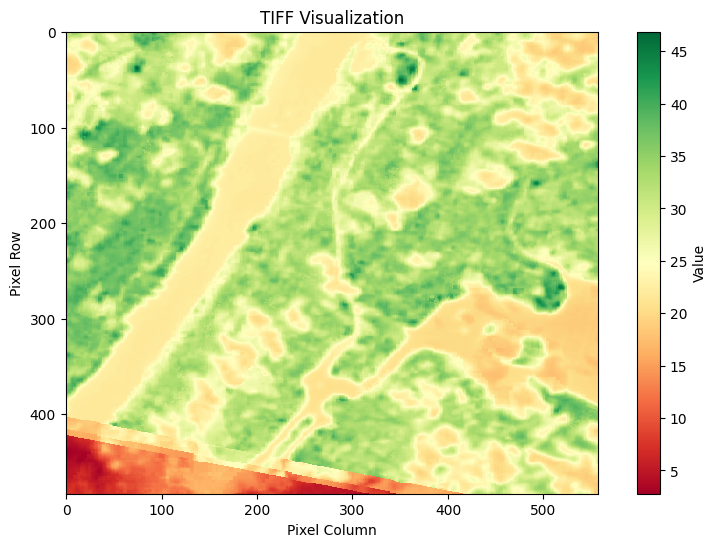

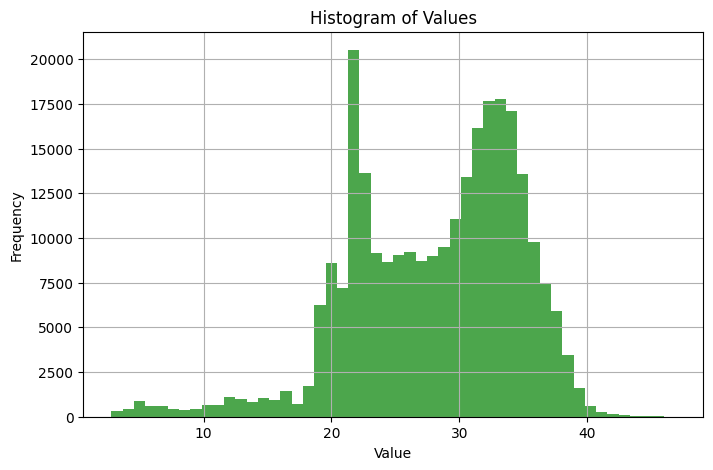

In [53]:
if SHOW_PLOTS:
    # Open the TIFF file
    with rasterio.open(lst_tiff_path) as src:
        # Print metadata
        print("Tiff Bounds:", src.bounds)
        print("CRS:", src.crs)
        print("Width, Height:", src.width, src.height)
        print("Number of bands:", src.count)
    
        # Read the first band (assuming it's a single-band raster or NDVI index)
        band1 = src.read(1)
    
    # Plot the raster data
    plt.figure(figsize=(10, 6))
    plt.imshow(band1, cmap='RdYlGn', interpolation='nearest')
    plt.colorbar(label="Value")
    plt.title("TIFF Visualization")
    plt.xlabel("Pixel Column")
    plt.ylabel("Pixel Row")
    plt.show()
    
    # Plot a histogram of NDVI values
    plt.figure(figsize=(8, 5))
    plt.hist(band1.flatten(), bins=50, color='green', alpha=0.7)
    plt.title("Histogram of Values")
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.grid()
    plt.show()

Tiff Bounds: BoundingBox(left=-74.0100610851599, bottom=40.75, right=-73.85995328781891, top=40.8800754581387)
CRS: EPSG:4326
Width, Height: 1671 1448
Number of bands: 5


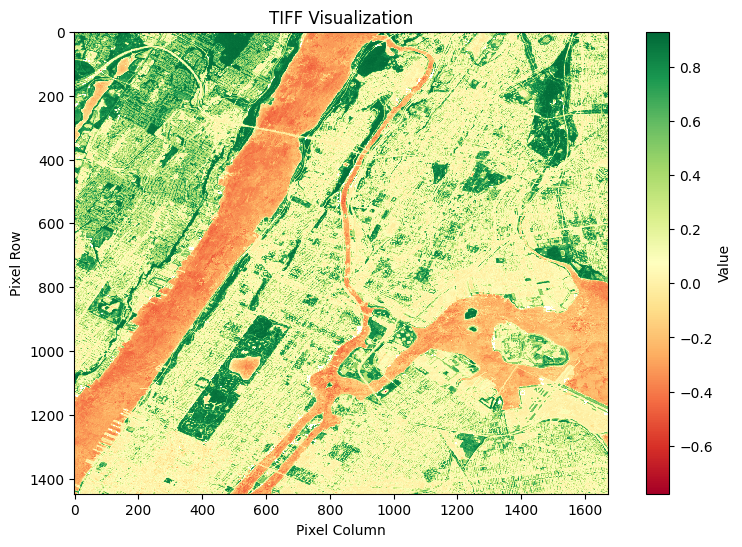

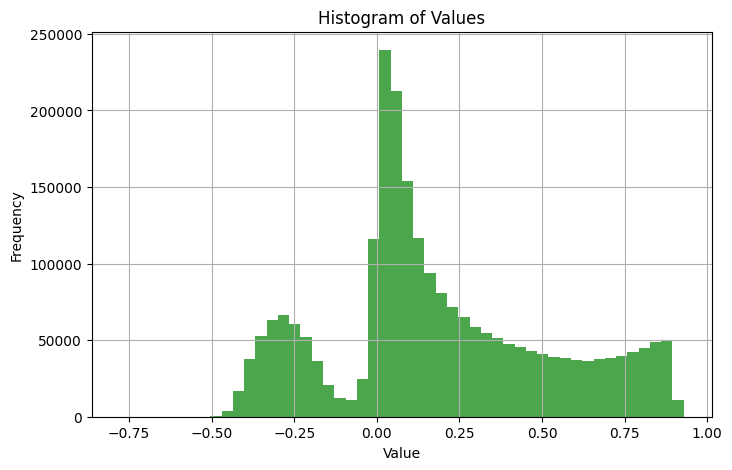

In [54]:
if SHOW_PLOTS:
    # Open the TIFF file
    with rasterio.open(indices_tiff_path) as src:
        # Print metadata
        print("Tiff Bounds:", src.bounds)
        print("CRS:", src.crs)
        print("Width, Height:", src.width, src.height)
        print("Number of bands:", src.count)
    
        # Read the first band (assuming it's a single-band raster or NDVI index)
        band1 = src.read(1)
    
    # Plot the raster data
    plt.figure(figsize=(10, 6))
    plt.imshow(band1, cmap='RdYlGn', interpolation='nearest')
    plt.colorbar(label="Value")
    plt.title("TIFF Visualization")
    plt.xlabel("Pixel Column")
    plt.ylabel("Pixel Row")
    plt.show()
    
    # Plot a histogram of NDVI values
    plt.figure(figsize=(8, 5))
    plt.hist(band1.flatten(), bins=50, color='green', alpha=0.7)
    plt.title("Histogram of Values")
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.grid()
    plt.show()

### LOAD TRAINING DATA

In [14]:
print("Loading Training CSV ...")
df_train = pd.read_csv("./data/Training_data_uhi_index_UHI2025-v2.csv")
print("df_train shape:", df_train.shape)

gdf_train = gpd.GeoDataFrame(
    df_train,
    geometry=[Point(lon, lat) for lon, lat in zip(df_train["Longitude"], df_train["Latitude"])],
    crs="EPSG:4326"
).to_crs("EPSG:2263")

# Extract bounds and create a spatial subset for buildings
minx_train, miny_train, maxx_train, maxy_train = gdf_train.total_bounds
buffer = 1500  # Buffer for the bounding box
expanded_bbox = shapely.geometry.box(minx_train - buffer, 
                    miny_train - buffer, 
                    maxx_train + buffer, 
                    maxy_train + buffer)

# Create a sub-dataframe from gdf_buildings that only contains features in the study area
gdf_buildings = gdf_buildings[gdf_buildings.geometry.intersects(expanded_bbox)]
gdf_buildings['centroid'] = gdf_buildings.geometry.centroid

# Also filter PLUTO data to study area to improve performance
gdf_pluto = gdf_pluto[gdf_pluto.geometry.intersects(expanded_bbox)]

print("Building footprints filtered to study area")
print(f"Number of buildings: {len(gdf_buildings)}")
print(f"Number of PLUTO parcels: {len(gdf_pluto)}")

Loading Training CSV ...
df_train shape: (11229, 4)
Building footprints filtered to study area
Number of buildings: 82392
Number of PLUTO parcels: 73390


154171


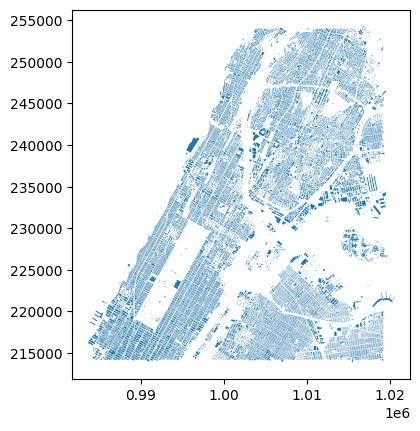

In [56]:
if SHOW_PLOTS:
    overlay_df = gpd.overlay(gdf_buildings, gdf_pluto, how="intersection")
    print(len(overlay_df))
    overlay_df.plot()

In [16]:
# Process BldgClass feature to reduce cardinality
print("Processing BldgClass feature...")
if "BldgClass" in gdf_pluto.columns:
    count = 20
    # Store original values
    gdf_pluto["BldgClass_Original"] = gdf_pluto["BldgClass"]
    
    # Get counts and print top classes to understand the data
    bldg_counts = gdf_pluto["BldgClass"].value_counts()
    print(f"Top {count} building classes by count:")
    print(bldg_counts.head(count))
    
    # Create a simplified grouping based on first character and documented codes
    def group_building_class(code):
        if pd.isna(code):
            return "Unknown"
            
        code_str = str(code)
        first_char = code_str[0] if len(code_str) > 0 else ""
        
        # Known special cases from the data dictionary
        if code in ["RC", "RD", "RI", "RM", "RX", "RZ"]:
            return "Condo_Mixed"
        elif code in ["R1", "R2", "R3", "R4", "R6", "RR"]:
            return "Condo_Residential"
        elif code in ["R5", "R7", "R8", "RA", "RB", "RH", "RK"]:
            return "Condo_Commercial"
        elif code == "RW":
            return "Condo_Industrial"
        elif code == "R9":
            return "Condo_Commercial_Residential"
        elif code in ["Q0", "QG"]:
            return "Parks_OpenSpace"
        
        # Group by first character for others
        first_char_groups = {
            "A": "Group_A",
            "B": "Group_B",
            "C": "Group_C",
            "D": "Group_D",
            "E": "Group_E",
            "F": "Group_F",
            "G": "Group_G",
            "H": "Group_H",
            "I": "Group_I",
            "J": "Group_J",
            "K": "Group_K",
            "L": "Group_L",
            "M": "Group_M",
            "N": "Group_N",
            "O": "Group_O",
            "P": "Group_P",
            "S": "Group_S",
            "T": "Group_T",
            "U": "Group_U",
            "V": "Group_V",
            "W": "Group_W",
            "Y": "Group_Y",
            "Z": "Group_Z"
        }
        
        return first_char_groups.get(first_char, "Other")
    
    # Apply the grouping function
    gdf_pluto["BldgClass"] = gdf_pluto["BldgClass"].apply(group_building_class)
    
    # Print stats
    original_count = gdf_pluto["BldgClass_Original"].nunique()
    new_count = gdf_pluto["BldgClass"].nunique()
    print(f"Reduced BldgClass cardinality from {original_count} to {new_count} categories")
    print(f"New building class categories: {sorted(gdf_pluto['BldgClass'].unique())}")

Processing BldgClass feature...
Top 20 building classes by count:
BldgClass
C0    9426
B1    7458
C1    5030
A5    4663
C7    3458
B2    3411
B3    2821
D1    2017
C2    1916
C3    1718
C4    1662
C5    1579
D4    1473
D7    1093
K1    1087
V1    1082
C6    1058
A4     987
G7     955
S2     954
Name: count, dtype: int64
Reduced BldgClass cardinality from 203 to 30 categories
New building class categories: ['Condo_Commercial', 'Condo_Commercial_Residential', 'Condo_Industrial', 'Condo_Mixed', 'Condo_Residential', 'Group_A', 'Group_B', 'Group_C', 'Group_D', 'Group_E', 'Group_F', 'Group_G', 'Group_H', 'Group_I', 'Group_J', 'Group_K', 'Group_M', 'Group_N', 'Group_O', 'Group_P', 'Group_S', 'Group_T', 'Group_U', 'Group_V', 'Group_W', 'Group_Y', 'Group_Z', 'Other', 'Parks_OpenSpace', 'Unknown']


In [17]:
gdf_pluto.describe(include='all')

,Borough,Block,Lot,CD,BCT2020,BCTCB2020,CT2010,CB2010,SchoolDist,Council,ZipCode,FireComp,PolicePrct,HealthCent,HealthArea,Sanitboro,SanitDistr,SanitSub,Address,ZoneDist1,ZoneDist2,ZoneDist3,ZoneDist4,Overlay1,Overlay2,SPDist1,SPDist2,SPDist3,LtdHeight,SplitZone,BldgClass,LandUse,Easements,OwnerType,OwnerName,LotArea,BldgArea,ComArea,ResArea,OfficeArea,RetailArea,GarageArea,StrgeArea,FactryArea,OtherArea,AreaSource,NumBldgs,NumFloors,UnitsRes,UnitsTotal,LotFront,LotDepth,BldgFront,BldgDepth,Ext,ProxCode,IrrLotCode,LotType,BsmtCode,AssessLand,AssessTot,ExemptTot,YearBuilt,YearAlter1,YearAlter2,HistDist,Landmark,BuiltFAR,ResidFAR,CommFAR,FacilFAR,BoroCode,BBL,CondoNo,Tract2010,XCoord,YCoord,ZoneMap,ZMCode,Sanborn,TaxMap,EDesigNum,APPBBL,APPDate,PLUTOMapID,FIRM07_FLA,PFIRM15_FL,Version,DCPEdited,Latitude,Longitude,Notes,Shape_Leng,Shape_Area,geometry,BldgClass_Original
count,73390,73390.000000,73390.000000,73390.000000,73390,73390,73390,73390,73329,73390.000000,73390.000000,73325,73390.000000,73390.000000,73390.000000,73309,73309,73276,73332,73388,3143,57,3,10215,54,7791,265,0,811,73388,73390,73045,73390.000000,7664,73345,7.339000e+04,7.339000e+04,7.339000e+04,7.339000e+04,7.339000e+04,7.339000e+04,7.339000e+04,73390.000000,73390.000000,7.339000e+04,73347,73390.000000,73390.000000,73390.000000,73390.000000,73390.000000,73390.000000,73390.000000,73390.000000,66501,73347,73347,73347,73347,7.339000e+04,7.339000e+04,7.339000e+04,73390.000000,73390.000000,73390.000000,7553,563,73390.000000,73390.000000,73390.000000,73390.000000,73390.000000,7.339000e+04,73390.000000,73390,7.339000e+04,73390.000000,73390,1543,73315,73315,2191,7.339000e+04,9645,73390,1633,2228,73390,8469,73390.000000,73390.000000,0,73390.0,7.339000e+04,73390,73348
unique,3,NaN,NaN,NaN,454,4341,328,192,12,NaN,NaN,93,NaN,NaN,NaN,3,14,41,71892,116,97,32,3,9,6,32,8,0,1,2,30,11,NaN,5,60738,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,4,2,10,6,NaN,NaN,NaN,NaN,NaN,NaN,50,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,328,NaN,NaN,17,1,1372,119,188,NaN,2285,2,1,1,1,1,NaN,NaN,0,NaN,NaN,73390,203
top,MN,NaN,NaN,NaN,4030903,40065023000,309.02,1000,30,NaN,NaN,E263,NaN,NaN,NaN,1,01,1A,PARK AVENUE,R7-1,R8B,R8B,C5-2.5,C1-4,C1-4,CL,TA,NaN,LH-1A,N,Group_C,02,NaN,X,UNAVAILABLE OWNER,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,3,N,5,2,NaN,NaN,NaN,NaN,NaN,NaN,Upper West Side / Central Park West Historic D...,INDIVIDUAL LANDMARK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,030902,NaN,NaN,9a,Y,402 057,40601,E-442,NaN,08/25/1988,1,1,1,24v4,t,NaN,NaN,NaN,NaN,NaN,POLYGON ((984244.9158754349 215966.97505760193...,C0
freq,25286,NaN,NaN,NaN,997,99,1006,7336,24588,NaN,NaN,3701,NaN,NaN,NaN,25243,22402,10832,34,9716,511,5,1,4046,20,1329,229,NaN,811,70004,25938,22809,NaN,5087,1139,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,68914,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46105,29436,59682,59306,31537,NaN,NaN,NaN,NaN,NaN,NaN,1751,504,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1006,NaN,NaN,10740,1543,433,2417,284,NaN,262,73347,1633,2228,73390,8469,NaN,NaN,NaN,NaN,NaN,1,9426
mean,NaN,1758.270623,231.220207,237.320493,NaN,NaN,NaN,NaN,NaN,14.706513,10547.923450,NaN,60.570228,26.091021,2055.631857,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.005764,NaN,NaN,1.038190e+04,2.049201e+04,6.972060e+03,1.262685e+04,2.922790e+03,9.615228e+02,5.349031e+02,248.327020,243.152214,2.048753e+03,NaN,1.135795,3.724304,13.282668,14.341000,49.684512,106.678837,36.954364,61.612446,NaN,NaN,NaN,NaN,NaN,5.122633e+05,2.280057e+06,7.367796e+05,1934.249680,553.683772,92.037117,NaN,NaN,2.333028,3.209600,0.572563,4.411864,2.325821,2.343404e+09,33.111418,NaN,1.005547e+06,229827.190721,NaN,NaN,NaN,NaN,NaN,2.694467e+08,NaN,NaN,NaN,NaN,NaN,NaN,40.797469,-73.923077,NaN,0.0,9.810772e+03,NaN,NaN
std,NaN,884.701481,1135.388035,122.946556,NaN,NaN,NaN,NaN,NaN,6.915317,584.910351,NaN,39.163127,11.596856,1703.708960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.100046,NaN,NaN,2.296437e+05,9.927595e+

In [18]:
# Run DBSCAN on buildings
N_LARGEST = 5
eps_m = 500
min_samples = 50
gdf_buildings, cluster_centroids, top_clusters = run_dbscan_on_buildings(
    gdf_buildings, 
    eps_m=eps_m,
    min_samples=min_samples,
    N_LARGEST=N_LARGEST
)

print(f"Top {N_LARGEST} clusters by building count: {top_clusters}")
print("Cluster centroids for top N largest clusters:")
for (lbl, (cx, cy)) in cluster_centroids:
    print(f"  Cluster {lbl} => centroid=({cx:.2f}, {cy:.2f})")

Top 5 clusters by building count: [3 0 2 5 1]
Cluster centroids for top N largest clusters:
  Cluster 3 => centroid=(1009881.93, 218371.84)
  Cluster 0 => centroid=(996856.53, 229556.64)
  Cluster 2 => centroid=(1010724.93, 238797.23)
  Cluster 5 => centroid=(1012355.38, 249621.08)
  Cluster 1 => centroid=(987239.19, 216725.97)


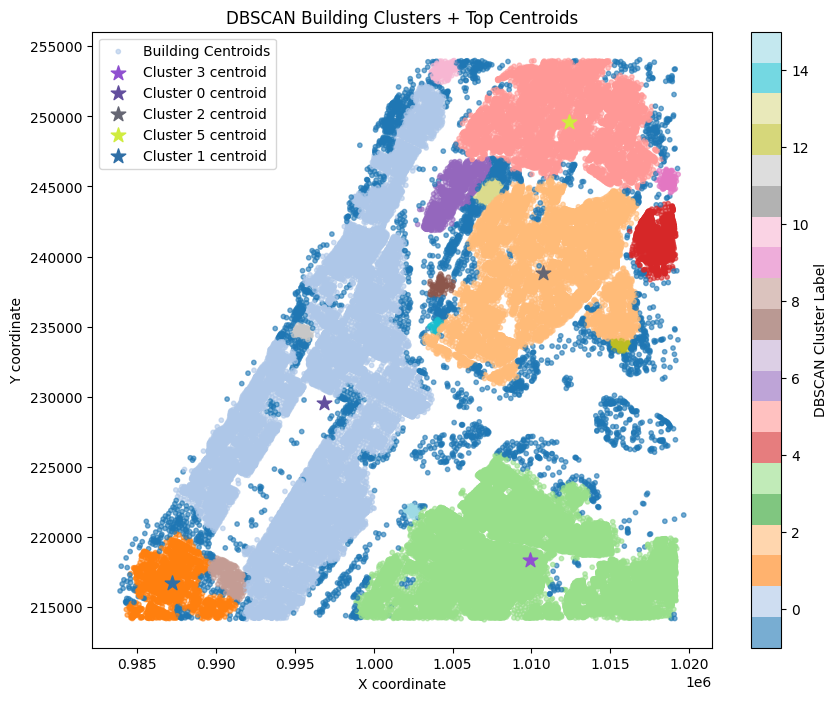

In [55]:
# Optional: Visualize urban clusters
if SHOW_PLOTS:
    coords_bldg = np.column_stack([gdf_buildings["centroid"].x, gdf_buildings["centroid"].y])
    labels_bldg = gdf_buildings["bldg_cluster"].values
    
    fig, ax = plt.subplots(figsize=(10, 8))
    scatter = ax.scatter(
        coords_bldg[:, 0],
        coords_bldg[:, 1],
        c=labels_bldg,
        cmap='tab20',
        s=10,
        alpha=0.6,
        label="Building Centroids"
    )
    # Mark cluster centroids
    for (lbl, (cx, cy)) in cluster_centroids:
        random_color = mcolors.to_rgba((random.random(), random.random(), random.random()))
        ax.scatter(cx, cy, color=random_color, marker='*', s=120, label=f"Cluster {lbl} centroid")
    
    ax.set_title("DBSCAN Building Clusters + Top Centroids")
    ax.set_xlabel("X coordinate")
    ax.set_ylabel("Y coordinate")
    cb = plt.colorbar(scatter, ax=ax, label="DBSCAN Cluster Label")
    
    # Deduplicate legend entries
    handles, labels_ = ax.get_legend_handles_labels()
    by_label = dict(zip(labels_, handles))
    ax.legend(by_label.values(), by_label.keys(), loc="best")
    
    plt.show()

### BUILD TRAINING FEATURES

In [20]:
print("Building training features...")
features_dict_train, pluto_features_dict_train = extract_advanced_features(
    gdf_train, 
    gdf_buildings=gdf_buildings,
    gdf_water=gdf_water,
    gdf_parks=gdf_parks,
    gdf_trees_poly=gdf_trees_poly,
    gdf_stations=gdf_stations,
    lst_raster_2263=lst_raster_2263,
    indices_raster_2263=indices_raster_2263,
    gdf_pluto=gdf_pluto
)

Building training features...
Extracting advanced features for 11229 points...
Extracting features for 11229 points...
  -> 0.00% done
  -> 4.45% done
  -> 8.91% done
  -> 13.36% done
  -> 17.81% done
  -> 22.26% done
  -> 26.72% done
  -> 31.17% done
  -> 35.62% done
  -> 40.07% done
  -> 44.53% done
  -> 48.98% done
  -> 53.43% done
  -> 57.89% done
  -> 62.34% done
  -> 66.79% done
  -> 71.24% done
  -> 75.70% done
  -> 80.15% done
  -> 84.60% done
  -> 89.06% done
  -> 93.51% done
  -> 97.96% done
100.00% done
  -> Advanced features: 0.00% done
  -> Advanced features: 4.45% done
  -> Advanced features: 8.91% done
  -> Advanced features: 13.36% done
  -> Advanced features: 17.81% done
  -> Advanced features: 22.26% done
  -> Advanced features: 26.72% done
  -> Advanced features: 31.17% done
  -> Advanced features: 35.62% done
  -> Advanced features: 40.07% done
  -> Advanced features: 44.53% done
  -> Advanced features: 48.98% done
  -> Advanced features: 53.43% done
  -> Advanced f

In [24]:
# Add per-point features to dataframe
for feat_key, feat_values in features_dict_train.items():
    print(f"Per-point: {feat_key}: {len(feat_values)}")

# Add PLUTO features to dataframe
if FEATURE_FLAGS["map_pluto_data"]:
    for col, values in pluto_features_dict_train.items():
        print(f"PLUTO: {col}: {len(values)}")

Per-point: building_cov_250m: 11229
Per-point: building_cov_500m: 11229
Per-point: building_cov_750m: 11229
Per-point: building_cov_1000m: 11229
Per-point: building_cov_std: 11229
Per-point: distance_water: 11229
Per-point: distance_water_exp: 11229
Per-point: distance_parks: 11229
Per-point: distance_parks_exp: 11229
Per-point: distance_water_quad: 0
Per-point: distance_parks_quad: 0
Per-point: street_tree_cov_250m: 11229
Per-point: street_tree_cov_500m: 11229
Per-point: street_tree_cov_750m: 11229
Per-point: street_tree_cov_1000m: 11229
Per-point: dist_to_closest_subway_station: 11229
Per-point: dist_to_closest_subway_exp: 11229
Per-point: dist_to_closest_urban_centre: 11229
Per-point: dist_to_closest_urban_centre_exp: 11229
Per-point: urban_cluster_id: 11229
Per-point: lst_value: 11229
Per-point: ndvi_value: 11229
Per-point: ndbi_value: 11229
Per-point: ndwi_value: 11229
Per-point: evi_value: 11229
Per-point: mndwi_value: 11229
Per-point: bldg_lst_interaction: 0
Per-point: ndvi_bldg

In [25]:
# Add only non-empty features from the features dictionary
for feat_key, feat_values in features_dict_train.items():
    if len(feat_values) > 0:  # Only add non-empty feature lists
        print(f"Adding per-point feature: {feat_key}: {len(feat_values)}")
        gdf_train[feat_key] = feat_values
    else:
        print(f"Skipping empty feature: {feat_key}")

# Add PLUTO features to dataframe
if FEATURE_FLAGS["map_pluto_data"]:
    for col, values in pluto_features_dict_train.items():
        print(f"Adding PLUTO feature: {col}: {len(values)}")
        gdf_train[col] = values
    
    # Fill missing values in PLUTO features
    for col in cat_cols:
        if col in gdf_train.columns:
            if col == "Borough":
                gdf_train[col] = gdf_train[col].fillna("MN")
            else:
                gdf_train[col] = gdf_train[col].fillna("UNKNOWN")
    
    # For year columns, convert zeros to NaN first
    year_cols = ["YearBuilt"]
    for col in year_cols:
        gdf_train[col] = gdf_train[col].replace(0, np.nan)
    
    for col in num_cols:
        if col in gdf_train.columns:
            # Fill missing numeric values with median
            median_val = gdf_train[col].median()
            gdf_train[col] = gdf_train[col].fillna(median_val)
    
    # Process categorical PLUTO columns via one-hot encoding
    total_cat_cols = cat_cols + ["urban_cluster_id"]
    for col in total_cat_cols:
        if col in gdf_train.columns:
            gdf_train[col] = gdf_train[col].astype(str)
    
    # Compute one-hot encoded dummy variables
    dummies = pd.get_dummies(gdf_train[total_cat_cols], prefix=total_cat_cols)
    
    # Store the list of dummy columns for later use
    dummy_cols_train = list(dummies.columns)
    
    # Drop the original categorical columns and concatenate the dummy variables
    gdf_train = gdf_train.drop(columns=total_cat_cols)
    gdf_train = pd.concat([gdf_train, dummies], axis=1)
    print("One-hot encoded PLUTO categorical features added to training data.")

# Create interaction features and add them to the dataframe
print("Creating interaction features...")
gdf_train = create_interaction_features(gdf_train)
print("Interaction features added to training data.")

# Print all column names for debugging
print("All columns in gdf_train:")
for col in gdf_train.columns:
    print(f"  - {col}")

# Prepare feature columns - only include what's actually in the dataframe
per_point_features = [k for k, v in FEATURE_FLAGS.items() 
                     if v and k != "map_pluto_data" and k != "advanced_interactions" 
                     and k in gdf_train.columns]

# Add PLUTO numeric features if enabled
pluto_numeric_features = []
if FEATURE_FLAGS["map_pluto_data"]:
    pluto_numeric_features = [col for col in pluto_columns if col in gdf_train.columns and col not in cat_cols]

# Add dummy variables if PLUTO is enabled
dummy_features = []
if FEATURE_FLAGS["map_pluto_data"] and 'dummy_cols_train' in locals():
    dummy_features = dummy_cols_train

# Combine all feature types
all_feature_cols = per_point_features + pluto_numeric_features + dummy_features

# Remove per-point categorical replaced by dummies
per_point_cat_features = ["urban_cluster_id"]
for feature in per_point_cat_features:
    if feature in all_feature_cols:
        all_feature_cols.remove(feature)

# Ensure all feature columns are actually in the dataframe
available_feature_cols = [col for col in all_feature_cols if col in gdf_train.columns]
print(f"Found {len(available_feature_cols)} available features out of {len(all_feature_cols)} total feature columns")

# Create dataframe with just the features
df_train_feat = gdf_train[available_feature_cols].copy()

# Handle model-specific categorical features (non-PLUTO)
model_cat_cols = ["urban_cluster_id", "micro_climate_zone"]
for cat_col in model_cat_cols:
    if cat_col in df_train_feat.columns:
        df_train_feat[cat_col] = df_train_feat[cat_col].astype(str)
        train_dummies = pd.get_dummies(df_train_feat[cat_col], prefix=cat_col)
        df_train_feat = pd.concat([df_train_feat.drop(columns=[cat_col]), train_dummies], axis=1)

# Fill NA values with intelligent strategies based on feature type
numeric_cols = df_train_feat.select_dtypes(include=np.number).columns
for col in numeric_cols:
    if df_train_feat[col].isna().any():
        # Use median for distance-based features (more robust than mean)
        if 'distance' in col or 'dist_' in col:
            df_train_feat[col] = df_train_feat[col].fillna(df_train_feat[col].median())
        else:
            # Use mean for other numeric features
            df_train_feat[col] = df_train_feat[col].fillna(df_train_feat[col].mean())

# Apply feature scaling for distance-based algorithms
scaler = StandardScaler()
# Store column names to reconstruct dataframe after scaling
cols = df_train_feat.columns
# Scale features
X_scaled = scaler.fit_transform(df_train_feat.values)
# Reconstruct dataframe with scaled values
df_train_feat_scaled = pd.DataFrame(X_scaled, columns=cols)
# Get original features and target
X = df_train_feat.values
X_scaled = df_train_feat_scaled.values
y = gdf_train["UHI Index"].values

print(f"Final feature matrix shape: {X.shape}")
print(f"Number of features: {X.shape[1]}")

Adding per-point feature: building_cov_250m: 11229
Adding per-point feature: building_cov_500m: 11229
Adding per-point feature: building_cov_750m: 11229
Adding per-point feature: building_cov_1000m: 11229
Adding per-point feature: building_cov_std: 11229
Adding per-point feature: distance_water: 11229
Adding per-point feature: distance_water_exp: 11229
Adding per-point feature: distance_parks: 11229
Adding per-point feature: distance_parks_exp: 11229
Skipping empty feature: distance_water_quad
Skipping empty feature: distance_parks_quad
Adding per-point feature: street_tree_cov_250m: 11229
Adding per-point feature: street_tree_cov_500m: 11229
Adding per-point feature: street_tree_cov_750m: 11229
Adding per-point feature: street_tree_cov_1000m: 11229
Adding per-point feature: dist_to_closest_subway_station: 11229
Adding per-point feature: dist_to_closest_subway_exp: 11229
Adding per-point feature: dist_to_closest_urban_centre: 11229
Adding per-point feature: dist_to_closest_urban_centre

In [26]:
# Add interaction features
gdf_train = create_interaction_features(gdf_train)

In [28]:
print("Loading validation (submission) data...")
df_val = pd.read_csv("./data/Submission_template_UHI2025-v2.csv")

gdf_val = gpd.GeoDataFrame(
    df_val,
    geometry=[Point(lon, lat) for lon, lat in zip(df_val.Longitude, df_val.Latitude)],
    crs="EPSG:4326"
).to_crs("EPSG:2263")

Loading validation (submission) data...


In [29]:
# Extract features for validation data
print("Building validation features...")
features_dict_val, pluto_features_dict_val = extract_advanced_features(
    gdf_val,
    gdf_buildings=gdf_buildings,
    gdf_water=gdf_water,
    gdf_parks=gdf_parks,
    gdf_trees_poly=gdf_trees_poly,
    gdf_stations=gdf_stations,
    lst_raster_2263=lst_raster_2263,
    indices_raster_2263=indices_raster_2263,
    gdf_pluto=gdf_pluto
)

Building validation features...
Extracting advanced features for 1040 points...
Extracting features for 1040 points...
  -> 0.00% done
  -> 48.08% done
  -> 96.15% done
100.00% done
  -> Advanced features: 0.00% done
  -> Advanced features: 48.08% done
  -> Advanced features: 96.15% done
100.00% done


In [30]:
# Add only non-empty features from the features dictionary
for feat_key, feat_values in features_dict_val.items():
    if len(feat_values) > 0:  # Only add non-empty feature lists
        print(f"Adding per-point feature: {feat_key}: {len(feat_values)}")
        gdf_val[feat_key] = feat_values
    else:
        print(f"Skipping empty feature: {feat_key}")

# Add PLUTO features to validation dataframe
if FEATURE_FLAGS["map_pluto_data"]:
    for col, values in pluto_features_dict_val.items():
        print(f"Adding PLUTO feature: {col}: {len(values)}")
        gdf_val[col] = values
    
    # Fill missing values in PLUTO features
    for col in cat_cols:
        if col in gdf_val.columns:
            if col == "Borough":
                gdf_val[col] = gdf_val[col].fillna("MN")
            else:
                gdf_val[col] = gdf_val[col].fillna("UNKNOWN")
    
    # For year columns, convert zeros to NaN first
    year_cols = ["YearBuilt"]
    for col in year_cols:
        gdf_val[col] = gdf_val[col].replace(0, np.nan)
    
    for col in num_cols:
        if col in gdf_val.columns:
            # Fill missing numeric values with median
            median_val = gdf_val[col].median()
            gdf_val[col] = gdf_val[col].fillna(median_val)
    
    # Process categorical PLUTO columns via one-hot encoding
    total_cat_cols = cat_cols + ["urban_cluster_id"]
    for col in total_cat_cols:
        if col in gdf_val.columns:
            gdf_val[col] = gdf_val[col].astype(str)
    
    # MODIFIED SECTION: Create consistent dummy variables
    print("Using consistent dummy encoding between training and validation...")
    
    # First, collect all possible categories from training dummies
    training_categories = {}
    for col in dummy_cols_train:
        # Extract the original column name and category from the dummy column name
        parts = col.split('_')
        if len(parts) >= 2:
            # The prefix is everything before the last underscore
            prefix = '_'.join(parts[:-1])
            # The category is after the last underscore
            category = parts[-1]
            
            if prefix not in training_categories:
                training_categories[prefix] = []
            training_categories[prefix].append(category)
    
    # Now create dummies with these categories for validation
    dummies_val = pd.DataFrame(index=gdf_val.index)
    for prefix in total_cat_cols:
        if prefix in training_categories and prefix in gdf_val.columns:
            # Create dummies for this column
            temp_dummies = pd.get_dummies(gdf_val[prefix], prefix=prefix)
            
            # Add missing columns (as False) to match training
            for cat in training_categories[prefix]:
                dummy_col = f"{prefix}_{cat}"
                if dummy_col not in temp_dummies.columns:
                    temp_dummies[dummy_col] = False
            
            # Add these dummies to our result
            dummies_val = pd.concat([dummies_val, temp_dummies], axis=1)
    
    # Make sure we have all the same dummy columns as training
    for col in dummy_cols_train:
        if col not in dummies_val.columns:
            dummies_val[col] = False
    
    # Ensure same column order as training dummies
    dummies_val = dummies_val[dummy_cols_train]
    
    # Drop the original categorical columns and concatenate the dummy variables
    gdf_val = gdf_val.drop(columns=[col for col in total_cat_cols if col in gdf_val.columns])
    gdf_val = pd.concat([gdf_val, dummies_val], axis=1)
    print("One-hot encoded PLUTO categorical features added to validation data.")

# Create interaction features
print("Creating interaction features for validation data...")
gdf_val = create_interaction_features(gdf_val)
print("Interaction features added to validation data.")

# Print all column names for debugging
print("All columns in gdf_val:")
print(f"Total columns: {len(gdf_val.columns)}")

# Create a version of feature_cols without the spatial autocorrelation features
train_cols_no_spatial = [col for col in cols]

# Create training matrix without spatial features (for model training)
X_model = df_train_feat[train_cols_no_spatial].values

# Create a NEW scaler fitted only on the features we'll use for modeling
model_scaler = StandardScaler()
X_model_scaled = model_scaler.fit_transform(X_model)

# Prepare validation and training data
df_train_feat = df_train_feat[train_cols_no_spatial]
df_val_feat = pd.DataFrame()

# Prepare per-point features for validation - only include what's actually in the dataframe
per_point_features_val = [k for k, v in FEATURE_FLAGS.items() 
                         if v and k != "map_pluto_data" and k != "advanced_interactions" 
                         and k in gdf_val.columns]

# Add available features to df_val_feat
for feat in per_point_features_val:
    if feat in gdf_val.columns:
        df_val_feat[feat] = gdf_val[feat]

# Add PLUTO numeric features if enabled
if FEATURE_FLAGS["map_pluto_data"]:
    for col in pluto_numeric_features:
        if col in gdf_val.columns:
            df_val_feat[col] = gdf_val[col]
    
    # Add dummy features with consistent types
    for col in dummy_cols_train:
        if col in dummies_val.columns:
            df_val_feat[col] = dummies_val[col]  # This preserves the boolean type
        else:
            df_val_feat[col] = False  # Use False for missing dummy columns to maintain boolean type

# Check which columns from train_cols_no_spatial are not in df_val_feat
missing_cols = [col for col in train_cols_no_spatial if col not in df_val_feat.columns]
print(f"Missing {len(missing_cols)} columns in validation data. Adding default values.")

# Ensure validation data has the same columns as training
for col in train_cols_no_spatial:
    if col not in df_val_feat.columns:
        # Create with the same data type as in training
        if col in df_train_feat.columns:
            if df_train_feat[col].dtype == bool:
                df_val_feat[col] = False  # Boolean false instead of 0
            else:
                df_val_feat[col] = 0
        else:
            df_val_feat[col] = 0

# Ensure columns are in the same order
df_val_feat = df_val_feat[train_cols_no_spatial]

# Fill NA values
numeric_cols = df_val_feat.select_dtypes(include=np.number).columns
for col in numeric_cols:
    if df_val_feat[col].isna().any():
        if 'distance' in col or 'dist_' in col:
            df_val_feat[col] = df_val_feat[col].fillna(df_val_feat[col].median())
        else:
            df_val_feat[col] = df_val_feat[col].fillna(df_val_feat[col].mean())

# Final check for data type consistency
inconsistent_cols = []
for col in train_cols_no_spatial:
    if col in df_train_feat.columns and col in df_val_feat.columns:
        if df_train_feat[col].dtype != df_val_feat[col].dtype:
            inconsistent_cols.append((col, df_train_feat[col].dtype, df_val_feat[col].dtype))
            # Force same type as training
            df_val_feat[col] = df_val_feat[col].astype(df_train_feat[col].dtype)

if inconsistent_cols:
    print(f"Fixed {len(inconsistent_cols)} columns with inconsistent types")

# Apply feature scaling using the new scaler
X_val = df_val_feat.values
X_val_scaled = model_scaler.transform(X_val)

print(f"Training data for modeling: {X_model.shape}")
print(f"Validation data: {X_val.shape}")

Adding per-point feature: building_cov_250m: 1040
Adding per-point feature: building_cov_500m: 1040
Adding per-point feature: building_cov_750m: 1040
Adding per-point feature: building_cov_1000m: 1040
Adding per-point feature: building_cov_std: 1040
Adding per-point feature: distance_water: 1040
Adding per-point feature: distance_water_exp: 1040
Adding per-point feature: distance_parks: 1040
Adding per-point feature: distance_parks_exp: 1040
Skipping empty feature: distance_water_quad
Skipping empty feature: distance_parks_quad
Adding per-point feature: street_tree_cov_250m: 1040
Adding per-point feature: street_tree_cov_500m: 1040
Adding per-point feature: street_tree_cov_750m: 1040
Adding per-point feature: street_tree_cov_1000m: 1040
Adding per-point feature: dist_to_closest_subway_station: 1040
Adding per-point feature: dist_to_closest_subway_exp: 1040
Adding per-point feature: dist_to_closest_urban_centre: 1040
Adding per-point feature: dist_to_closest_urban_centre_exp: 1040
Addin

In [31]:
# Make sure these match
assert X_model.shape[1] == X_val.shape[1], "Feature count mismatch between training and validation"

In [32]:
df_train_feat.describe(include='all')

,building_cov_250m,building_cov_500m,building_cov_750m,building_cov_1000m,building_cov_std,distance_water,distance_water_exp,distance_parks,distance_parks_exp,distance_water_quad,distance_parks_quad,street_tree_cov_250m,street_tree_cov_500m,street_tree_cov_750m,street_tree_cov_1000m,dist_to_closest_subway_station,dist_to_closest_subway_exp,dist_to_closest_urban_centre,dist_to_closest_urban_centre_exp,lst_value,ndvi_value,ndbi_value,ndwi_value,evi_value,mndwi_value,bldg_lst_interaction,ndvi_bldg_interaction,water_park_interaction,lst_ndvi_interaction,building_density_gradient,urban_canyon_effect,distance_to_closest_water_park,neighborhood_lst_anomaly,NumFloors,NumBldgs,UnitsRes,UnitsTotal,LotArea,BldgArea,ComArea,ResArea,FactryArea,AssessLand,AssessTot,ExemptTot,BuiltFAR,ResidFAR,CommFAR,FacilFAR,YearBuilt,LandUse_01,LandUse_02,LandUse_03,LandUse_04,LandUse_05,LandUse_06,LandUse_07,LandUse_08,LandUse_09,LandUse_10,LandUse_11,LandUse_UNKNOWN,BldgClass_Condo_Commercial,BldgClass_Condo_Mixed,BldgClass_Condo_Residential,BldgClass_Group_A,BldgClass_Group_B,BldgClass_Group_C,BldgClass_Group_D,BldgClass_Group_E,BldgClass_Group_F,BldgClass_Group_G,BldgClass_Group_H,BldgClass_Group_I,BldgClass_Group_J,BldgClass_Group_K,BldgClass_Group_M,BldgClass_Group_N,BldgClass_Group_O,BldgClass_Group_P,BldgClass_Group_S,BldgClass_Group_T,BldgClass_Group_U,BldgClass_Group_V,BldgClass_Group_W,BldgClass_Group_Y,BldgClass_Group_Z,BldgClass_Other,BldgClass_Parks_OpenSpace,BldgClass_Unknown,urban_cluster_id_N0,urban_cluster_id_N1,urban_cluster_id_N2,urban_cluster_id_N5
count,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,1.122900e+04,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,1.122900e+04,1.122900e+04,1.122900e+04,11229.000000,11229.000000,1.122900e+04,1.122900e+04,1.122900e+04,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229,11229,11229,11229,11229,11229,11229,11229,11229,11229,11229,11229,11229,11229,11229,11229,11229,11229,11229,11229,11229,11229,11229,11229,11229,11229,11229,11229,11229,11229,11229,11229,11229,11229,11229,11229,11229,11229,11229,11229,11229,11229,11229,11229
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10995,10285,9405,8692,10337,10462,10827,9869,9731,10925,10901,11090,11210,10696,11088,11139,11085,9497,8640,10704,10987,10775,11141,11090,11209,10478,10999,11171,11051,11179,11074,11225,11057,10901,10416,11120,11095,9770,11183,11203,6840,10078,6877,9892
mean,0.312910,0.314795,0.308392,0.302396,0.063199,1891.184531,0.120258,362.798049,0.582835,0.179401,0.701848,0.001620,0.001550,0.001516,0.001494,1346.473005,0.281696,5509.436736,2.198227e-02,31.372035,0.209244,0.021330,-0.227787,1.708637,-0.254757,10.016953,0.153870,0.080202,6.271250,0.0000

In [33]:
df_val_feat.describe(include='all')

,building_cov_250m,building_cov_500m,building_cov_750m,building_cov_1000m,building_cov_std,distance_water,distance_water_exp,distance_parks,distance_parks_exp,distance_water_quad,distance_parks_quad,street_tree_cov_250m,street_tree_cov_500m,street_tree_cov_750m,street_tree_cov_1000m,dist_to_closest_subway_station,dist_to_closest_subway_exp,dist_to_closest_urban_centre,dist_to_closest_urban_centre_exp,lst_value,ndvi_value,ndbi_value,ndwi_value,evi_value,mndwi_value,bldg_lst_interaction,ndvi_bldg_interaction,water_park_interaction,lst_ndvi_interaction,building_density_gradient,urban_canyon_effect,distance_to_closest_water_park,neighborhood_lst_anomaly,NumFloors,NumBldgs,UnitsRes,UnitsTotal,LotArea,BldgArea,ComArea,ResArea,FactryArea,AssessLand,AssessTot,ExemptTot,BuiltFAR,ResidFAR,CommFAR,FacilFAR,YearBuilt,LandUse_01,LandUse_02,LandUse_03,LandUse_04,LandUse_05,LandUse_06,LandUse_07,LandUse_08,LandUse_09,LandUse_10,LandUse_11,LandUse_UNKNOWN,BldgClass_Condo_Commercial,BldgClass_Condo_Mixed,BldgClass_Condo_Residential,BldgClass_Group_A,BldgClass_Group_B,BldgClass_Group_C,BldgClass_Group_D,BldgClass_Group_E,BldgClass_Group_F,BldgClass_Group_G,BldgClass_Group_H,BldgClass_Group_I,BldgClass_Group_J,BldgClass_Group_K,BldgClass_Group_M,BldgClass_Group_N,BldgClass_Group_O,BldgClass_Group_P,BldgClass_Group_S,BldgClass_Group_T,BldgClass_Group_U,BldgClass_Group_V,BldgClass_Group_W,BldgClass_Group_Y,BldgClass_Group_Z,BldgClass_Other,BldgClass_Parks_OpenSpace,BldgClass_Unknown,urban_cluster_id_N0,urban_cluster_id_N1,urban_cluster_id_N2,urban_cluster_id_N5
count,1040.000000,1040.000000,1040.000000,1040.000000,1040.000000,1040.000000,1040.000000,1040.000000,1040.000000,1040.000000,1040.000000,1040.000000,1040.000000,1040.000000,1040.000000,1040.000000,1040.000000,1040.000000,1.040000e+03,1040.000000,1040.000000,1040.000000,1040.000000,1040.000000,1040.000000,1040.000000,1040.000000,1040.000000,1040.000000,1.040000e+03,1040.000000,1040.000000,1040.000000,1040.000000,1040.000000,1040.000000,1040.000000,1.040000e+03,1.040000e+03,1.040000e+03,1040.000000,1040.000000,1.040000e+03,1.040000e+03,1.040000e+03,1040.000000,1040.000000,1040.000000,1040.000000,1040.000000,1040,1040,1040,1040,1040,1040,1040,1040,1040,1040,1040,1040,1040,1040,1040,1040,1040,1040,1040,1040,1040,1040,1040,1040,1040,1040,1040,1040,1040,1040,1040,1040,1040,1040,1040,1040,1040,1040,1040,1040,1040,1040,1040,1040
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2,2,2,2,2,2,2
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1021,966,849,825,929,976,995,919,894,1021,1017,1028,1039,986,1033,1037,1024,906,773,999,1017,1007,1029,1023,1032,962,1020,1034,1016,1038,1032,1040,1020,1017,975,1022,1028,896,1038,1037,637,927,624,932
mean,0.316505,0.319223,0.313957,0.308287,0.064382,1862.946328,0.121319,354.089910,0.587944,0.181544,0.707239,0.001659,0.001580,0.001550,0.001523,1343.433165,0.285658,5508.093428,2.105371e-02,31.457096,0.210029,0.022228,-0.228936,3.075043,-0.257356,10.178997,0.152903,0.082496,6.289969,5.095097e-06,0.910078,335.445904,-0.038976,6.211770,5.450976,81.580156,84.301179,2.238870e+06,1.677846e+05,8.247589e+04,80865.028365,1925.727688,

### DEFINE STRATIFIED CV

In [34]:
print("Detecting outliers...")
outlier_detector = OutlierDetector(contamination=0.01)
outlier_mask = outlier_detector.fit_detect(X_model, y)
print(f"Detected {sum(outlier_mask)} outliers out of {len(X)} samples")

# Prepare clean data for modeling
X_clean = X_model[~outlier_mask]
X_scaled_clean = X_scaled[~outlier_mask]
y_clean = y[~outlier_mask]

### DEFINE STRATIFIED CV ON CLEANED DATA
# Enhanced stratification for cross-validation - now on cleaned data
def make_stratified_bins(target, n_bins=10):
    bins = pd.qcut(target, q=n_bins, duplicates="drop")
    return bins.astype(str)

# Create stratified bins for cross-validation on cleaned data
K_FOLDS = 10
y_bins_clean = make_stratified_bins(y_clean, n_bins=10)

# Set up cross-validation strategies on cleaned data
skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=RANDOM_SEED)

Detecting outliers...
Detected 113 outliers out of 11229 samples


In [35]:
# # spatial approach
# K_FOLDS = 10

# def create_optimized_spatial_folds(gdf, n_folds):
#     # Get coordinates
#     coords = np.column_stack([gdf.geometry.x, gdf.geometry.y])
    
#     # Use K-means with more initial clusters
#     kmeans = KMeans(n_clusters=n_folds, random_state=RANDOM_SEED)
#     spatial_groups = kmeans.fit_predict(coords)
    
#     unique_groups, counts = np.unique(spatial_groups, return_counts=True)
#     print("Spatial fold sizes:")
#     for group, count in zip(unique_groups, counts):
#         print(f"  Group {group}: {count} samples")
    
#     return spatial_groups

# # Create the folds
# spatial_groups = create_optimized_spatial_folds(gdf_train, K_FOLDS)

### MODEL DEFINITIONS & HYPERPARAMETERS GRID

In [46]:
# Define model candidates and hyperparameter spaces
def define_models_and_params():
    models_and_params = {
        "NeuralNetwork": (
            MLPRegressor(random_state=RANDOM_SEED, early_stopping=True),
            {
                "hidden_layer_sizes": [(50,), (100,), (50, 25), (100, 50), (100, 50, 25)],
                "activation": ["relu", "tanh"],
                "solver": ["adam"],
                "alpha": [0.0001, 0.001, 0.01],
                "learning_rate": ["adaptive"],
                "learning_rate_init": [0.001, 0.01],
                "max_iter": [300, 500],
                "batch_size": [32, 64, "auto"],
                "tol": [1e-4, 1e-5],
            },
            10
        ),
        "XGBoost": (
            xgb.XGBRegressor(random_state=RANDOM_SEED, use_label_encoder=False, eval_metric="rmse"),
            {
                "n_estimators": [100, 200, 300, 400, 500, 600, 800],
                "learning_rate": [0.005, 0.01, 0.02, 0.05, 0.1, 0.2],
                "max_depth": [10, 15, 20, 25, 30],
                "subsample": [0.7, 0.8, 0.9, 1.0],
                "colsample_bytree": [0.7, 0.8, 0.9, 1.0],
            },
            80
        ),
        "ExtraTrees": (
            ExtraTreesRegressor(random_state=RANDOM_SEED),
            {
                "n_estimators": [100, 200, 300, 400, 500, 600, 800],
                "max_depth": [10, 15, 20, 25, 30, 35, 40],
                "min_samples_split": [2, 3, 4, 5],
                "min_samples_leaf": [1, 2, 3, 4],
                "max_features": [1.0, "sqrt", "log2", 0.8],
            },
            100
        ),
        "CatBoost": (
            CatBoostRegressor(silent=True, random_state=RANDOM_SEED),
            {
                "iterations": [100, 200, 300, 400, 500, 600, 800],
                "max_depth": [5, 6, 7, 8, 9, 10, 11],
                "learning_rate": [0.005, 0.01, 0.02, 0.05, 0.1, 0.2],
                "random_strength": [1, 3, 5],
                "l2_leaf_reg": [1, 3, 5, 7, 9],
                "border_count": [32, 64, 128],
                "bagging_temperature": [0, 1, 10],
                
            },
            40
        ),
        "LightGBM": (
            lgb.LGBMRegressor(random_state=RANDOM_SEED, verbose=-1),
            {
                "n_estimators": [100, 200, 300, 400, 500, 600, 800],
                "max_depth": [10, 15, 20, 25, 30],
                "learning_rate": [0.005, 0.01, 0.02, 0.05, 0.1, 0.2],
                "subsample": [0.7, 0.8, 0.9, 1.0],
                "colsample_bytree": [0.7, 0.8, 0.9, 1.0],
                "num_leaves": [31, 63, 127, 255],
                "min_child_samples": [5, 10, 20, 50],
            },
            50
        ),
        "DecisionTree": (
            DecisionTreeRegressor(random_state=RANDOM_SEED),
            {
                "splitter": ["best", "random"],
                "max_depth": [10, 15, 20, 25, 30, 35, 40],
                "min_samples_leaf": [1, 2, 3, 4],
            },
            50
        ),
        "HistGradientBoosting": (
            HistGradientBoostingRegressor(random_state=RANDOM_SEED),
            {
                "max_iter": [100, 200, 300, 400, 500, 600, 800],
                "learning_rate": [0.005, 0.01, 0.02, 0.05, 0.1, 0.2],
                "max_depth": [10, 15, 20, 25, 30],
                "max_leaf_nodes": [31, 63, 127, 255],
                "l2_regularization": [0.0, 0.1, 0.5],
                "quantile": [0.1, 0.5, 0.8],
                "min_samples_leaf": [5, 10, 15],
            },
            50
        ),
        "RandomForest": (
            RandomForestRegressor(random_state=RANDOM_SEED),
            {
                "n_estimators": [100, 200, 300, 400, 500, 600, 800],
                "max_depth": [10, 15, 20, 25, 30],
                "min_samples_leaf": [1, 2, 3, 4],
                "min_samples_split": [2, 3, 4, 5],
                "max_features": [1.0, "sqrt", "log2", 0.8],
            },
            20
        ),
        "KNeighbors": (
            KNeighborsRegressor(),
            {
                "n_neighbors": [1, 2, 3, 4],
                "weights": ["uniform", "distance"],
                "p": [1, 2, 3],
                "algorithm": ['auto', 'ball_tree', 'kd_tree', 'brute'],
                "leaf_size": [5, 10, 15, 20, 25, 30, 35, 40],
                "metric": ['minkowski', 'euclidean', 'manhattan', 'chebyshev'],
            },
            200
        ),
    }
    return models_and_params

### HYPERPARAMETER SEARCH FOR EACH MODEL

In [47]:
results = []
models_and_params = define_models_and_params()

for model_name, (model, param_grid, n_iter) in models_and_params.items():
    print(f"\n=== Searching {model_name} ===")
    
    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        n_iter=n_iter,
        cv=list(skf.split(X_scaled_clean, y_bins_clean)),
        scoring="r2",
        random_state=RANDOM_SEED,
        n_jobs=-1,
        verbose=3
    )
    search.fit(X_scaled_clean, y_clean)

    best_estimator = search.best_estimator_
    best_score = search.best_score_
    best_params = search.best_params_

    results.append({
        "Model": model_name,
        "Best Estimator": best_estimator,
        "Best Score (CV)": best_score,
        "Best Params": best_params
    })

results_df = pd.DataFrame(results).sort_values(by="Best Score (CV)", ascending=False)


=== Searching NeuralNetwork ===
Fitting 10 folds for each of 10 candidates, totalling 100 fits

=== Searching XGBoost ===
Fitting 10 folds for each of 80 candidates, totalling 800 fits

=== Searching ExtraTrees ===
Fitting 10 folds for each of 100 candidates, totalling 1000 fits

=== Searching CatBoost ===
Fitting 10 folds for each of 40 candidates, totalling 400 fits

=== Searching LightGBM ===
Fitting 10 folds for each of 50 candidates, totalling 500 fits

=== Searching DecisionTree ===
Fitting 10 folds for each of 50 candidates, totalling 500 fits

=== Searching HistGradientBoosting ===
Fitting 10 folds for each of 50 candidates, totalling 500 fits

=== Searching RandomForest ===
Fitting 10 folds for each of 20 candidates, totalling 200 fits

=== Searching KNeighbors ===
Fitting 10 folds for each of 200 candidates, totalling 2000 fits


In [48]:
# Display top models
print("\nTop Models:")
for i, row in results_df.iterrows():
    print(f"\n{row['Model']}: {row['Best Score (CV)']:.4f} R2 score")
    print(f"Parameters: {row['Best Params']}")


Top Models:

ExtraTrees: 0.9761 R2 score
Parameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.8, 'max_depth': 35}

XGBoost: 0.9720 R2 score
Parameters: {'subsample': 0.9, 'n_estimators': 800, 'max_depth': 15, 'learning_rate': 0.01, 'colsample_bytree': 0.7}

LightGBM: 0.9686 R2 score
Parameters: {'subsample': 1.0, 'num_leaves': 255, 'n_estimators': 400, 'min_child_samples': 5, 'max_depth': 15, 'learning_rate': 0.02, 'colsample_bytree': 0.8}

RandomForest: 0.9667 R2 score
Parameters: {'n_estimators': 600, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.8, 'max_depth': 25}

CatBoost: 0.9635 R2 score
Parameters: {'random_strength': 1, 'max_depth': 9, 'learning_rate': 0.2, 'l2_leaf_reg': 3, 'iterations': 800, 'border_count': 64, 'bagging_temperature': 0}

HistGradientBoosting: 0.9579 R2 score
Parameters: {'quantile': 0.1, 'min_samples_leaf': 5, 'max_leaf_nodes': 127, 'max_iter': 400, 'max_depth': 25, 'learning_rate': 0.1, 'l2_r

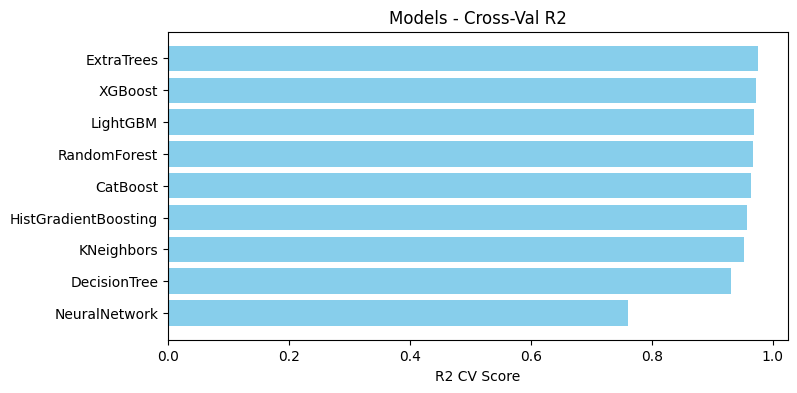

In [57]:
if SHOW_PLOTS:
    plt.figure(figsize=(8,4))
    plt.barh(results_df["Model"], results_df["Best Score (CV)"], color='skyblue')
    plt.gca().invert_yaxis()
    plt.xlabel("R2 CV Score")
    plt.title("Models - Cross-Val R2")
    plt.show()

In [58]:
# Advanced optimization for top model using Optuna
def optimize_top_model_with_optuna(top_model, X_clean, y_clean, y_bins_clean, skf):
    print(f"\n=== Advanced optimization for {top_model} ===")
    
    if top_model == "KNeighbors":
        # Define the objective function for KNeighbors
        def objective_knn(trial):
            n_neighbors = trial.suggest_int('n_neighbors', 1, 6)
            weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
            p = trial.suggest_int('p', 1, 3)
            algorithm = trial.suggest_categorical('algorithm', ['auto', 'ball_tree', 'kd_tree'])
            leaf_size = trial.suggest_int('leaf_size', 10, 50)
            metric = trial.suggest_categorical('metric', ['minkowski', 'euclidean', 'manhattan', 'chebyshev'])
            
            knn = KNeighborsRegressor(
                n_neighbors=n_neighbors,
                weights=weights,
                p=p,
                algorithm=algorithm,
                leaf_size=leaf_size,
                metric=metric
            )
            
            # Use stratified k-fold for evaluation
            cv_scores = cross_val_score(
                knn, X_clean, y_clean, 
                cv=list(skf.split(X_clean, y_bins_clean)), 
                scoring='r2', 
                n_jobs=-1
            )
            return np.mean(cv_scores)
        
        # Create study and optimize
        study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=RANDOM_SEED))
        study.optimize(objective_knn, n_trials=200)
        
        # Create best model
        best_params = study.best_params
        best_model = KNeighborsRegressor(
            n_neighbors=best_params['n_neighbors'],
            weights=best_params['weights'],
            p=best_params['p'],
            algorithm=best_params['algorithm'],
            leaf_size=best_params['leaf_size'],
            metric=best_params['metric']
        )
        
    elif top_model == "ExtraTrees":
        # Define the objective function for ExtraTrees
        def objective_et(trial):
            n_estimators = trial.suggest_int('n_estimators', 200, 800)
            max_depth = trial.suggest_int('max_depth', 20, 50)
            min_samples_split = trial.suggest_int('min_samples_split', 2, 4)
            min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 3)
            max_features = trial.suggest_float('max_features', 0.7, 1.0)
            bootstrap = trial.suggest_categorical('bootstrap', [False, True])
            
            et = ExtraTreesRegressor(
                n_estimators=n_estimators,
                max_depth=max_depth,
                min_samples_split=min_samples_split,
                min_samples_leaf=min_samples_leaf,
                max_features=max_features,
                bootstrap=bootstrap,
                random_state=RANDOM_SEED
            )
            
            cv_scores = cross_val_score(
                et, X_clean, y_clean, 
                cv=list(skf.split(X_clean, y_bins_clean)), 
                scoring='r2', 
                n_jobs=-1
            )
            return np.mean(cv_scores)
        
        # Create study and optimize
        study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=RANDOM_SEED))
        study.optimize(objective_et, n_trials=150)
        
        # Create best model
        best_params = study.best_params
        best_model = ExtraTreesRegressor(
            n_estimators=best_params['n_estimators'],
            max_depth=best_params['max_depth'],
            min_samples_split=best_params['min_samples_split'],
            min_samples_leaf=best_params['min_samples_leaf'],
            max_features=best_params['max_features'],
            bootstrap=best_params['bootstrap'],
            random_state=RANDOM_SEED
        )
        
    elif top_model == "XGBoost":
        # Define the objective function for XGBoost
        def objective_xgb(trial):
            n_estimators = trial.suggest_int('n_estimators', 300, 1000)
            learning_rate = trial.suggest_float('learning_rate', 0.005, 0.05, log=True)
            max_depth = trial.suggest_int('max_depth', 20, 50)
            subsample = trial.suggest_float('subsample', 0.7, 1.0)
            colsample_bytree = trial.suggest_float('colsample_bytree', 0.7, 1.0)
            min_child_weight = trial.suggest_int('min_child_weight', 1, 5)
            gamma = trial.suggest_float('gamma', 1e-8, 0.2, log=True)
            reg_alpha = trial.suggest_float('reg_alpha', 1e-8, 0.1, log=True)
            reg_lambda = trial.suggest_float('reg_lambda', 0.01, 1.0, log=True)
            
            xgb_model = xgb.XGBRegressor(
                n_estimators=n_estimators,
                learning_rate=learning_rate,
                max_depth=max_depth,
                subsample=subsample,
                colsample_bytree=colsample_bytree,
                min_child_weight=min_child_weight,
                gamma=gamma,
                reg_alpha=reg_alpha,
                reg_lambda=reg_lambda,
                random_state=RANDOM_SEED,
                use_label_encoder=False,
                eval_metric="rmse"
            )
            
            cv_scores = cross_val_score(
                xgb_model, X_clean, y_clean, 
                cv=list(skf.split(X_clean, y_bins_clean)), 
                scoring='r2', 
                n_jobs=-1
            )
            return np.mean(cv_scores)
        
        # Create study and optimize
        study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=RANDOM_SEED))
        study.optimize(objective_xgb, n_trials=150)
        
        # Create best model
        best_params = study.best_params
        best_model = xgb.XGBRegressor(
            n_estimators=best_params['n_estimators'],
            learning_rate=best_params['learning_rate'],
            max_depth=best_params['max_depth'],
            subsample=best_params['subsample'],
            colsample_bytree=best_params['colsample_bytree'],
            min_child_weight=best_params['min_child_weight'],
            gamma=best_params['gamma'],
            reg_alpha=best_params['reg_alpha'],
            reg_lambda=best_params['reg_lambda'],
            random_state=RANDOM_SEED,
            use_label_encoder=False,
            eval_metric="rmse"
        )
        
    elif top_model == "LightGBM":
        # Define the objective function for LightGBM
        def objective_lgbm(trial):
            n_estimators = trial.suggest_int('n_estimators', 300, 1000)
            learning_rate = trial.suggest_float('learning_rate', 0.005, 0.05, log=True)
            max_depth = trial.suggest_int('max_depth', 20, 50)
            num_leaves = trial.suggest_int('num_leaves', 31, 255)
            subsample = trial.suggest_float('subsample', 0.7, 1.0)
            colsample_bytree = trial.suggest_float('colsample_bytree', 0.7, 1.0)
            min_child_samples = trial.suggest_int('min_child_samples', 5, 50)
            reg_alpha = trial.suggest_float('reg_alpha', 1e-8, 0.1, log=True)
            reg_lambda = trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True)
            
            lgbm_model = lgb.LGBMRegressor(
                n_estimators=n_estimators,
                learning_rate=learning_rate,
                max_depth=max_depth,
                num_leaves=num_leaves,
                subsample=subsample,
                colsample_bytree=colsample_bytree,
                min_child_samples=min_child_samples,
                reg_alpha=reg_alpha,
                reg_lambda=reg_lambda,
                random_state=RANDOM_SEED,
                verbose=-1
            )
            
            cv_scores = cross_val_score(
                lgbm_model, X_clean, y_clean, 
                cv=list(skf.split(X_clean, y_bins_clean)), 
                scoring='r2', 
                n_jobs=-1
            )
            return np.mean(cv_scores)
        
        # Create study and optimize
        study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=RANDOM_SEED))
        study.optimize(objective_lgbm, n_trials=150)
        
        # Create best model
        best_params = study.best_params
        best_model = lgb.LGBMRegressor(
            n_estimators=best_params['n_estimators'],
            learning_rate=best_params['learning_rate'],
            max_depth=best_params['max_depth'],
            num_leaves=best_params['num_leaves'],
            subsample=best_params['subsample'],
            colsample_bytree=best_params['colsample_bytree'],
            min_child_samples=best_params['min_child_samples'],
            reg_alpha=best_params.get('reg_alpha', 0.0),
            reg_lambda=best_params.get('reg_lambda', 0.0),
            random_state=RANDOM_SEED,
            verbose=-1
        )
        
    elif top_model == "NeuralNetwork":
        # Define the objective function for Neural Network
        def objective_nn(trial):
            # Layer configuration
            n_layers = trial.suggest_int('n_layers', 1, 3)
            layers = []
            for i in range(n_layers):
                layers.append(trial.suggest_int(f'n_units_l{i}', 20, 200))
            hidden_layer_sizes = tuple(layers)
            
            activation = trial.suggest_categorical('activation', ['relu', 'tanh'])
            alpha = trial.suggest_float('alpha', 1e-5, 1e-2, log=True)
            learning_rate_init = trial.suggest_float('learning_rate_init', 1e-4, 1e-2, log=True)
            batch_size = trial.suggest_categorical('batch_size', [32, 64, 128, 'auto'])
            
            nn_model = MLPRegressor(
                hidden_layer_sizes=hidden_layer_sizes,
                activation=activation,
                solver='adam',
                alpha=alpha,
                batch_size=batch_size,
                learning_rate='adaptive',
                learning_rate_init=learning_rate_init,
                max_iter=500,
                early_stopping=True,
                validation_fraction=0.1,
                random_state=RANDOM_SEED
            )
            
            cv_scores = cross_val_score(
                nn_model, X_clean, y_clean, 
                cv=list(skf.split(X_clean, y_bins_clean)), 
                scoring='r2', 
                n_jobs=-1
            )
            return np.mean(cv_scores)
        
        # Create study and optimize
        study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=RANDOM_SEED))
        study.optimize(objective_nn, n_trials=100)
        
        # Create best model
        best_params = study.best_params
        
        # Reconstruct hidden_layer_sizes from individual layer parameters
        n_layers = best_params['n_layers']
        hidden_layer_sizes = []
        for i in range(n_layers):
            hidden_layer_sizes.append(best_params[f'n_units_l{i}'])
        
        best_model = MLPRegressor(
            hidden_layer_sizes=tuple(hidden_layer_sizes),
            activation=best_params['activation'],
            solver='adam',
            alpha=best_params['alpha'],
            batch_size=best_params['batch_size'],
            learning_rate='adaptive',
            learning_rate_init=best_params['learning_rate_init'],
            max_iter=500,
            early_stopping=True,
            validation_fraction=0.1,
            random_state=RANDOM_SEED
        )
        
    else:
        # Handle any other model type (just in case)
        print(f"No specific optimization strategy for {top_model}. Using the best model from grid search.")
        best_model = results_df.iloc[0]["Best Estimator"]
        best_params = None
        study = None
    
    # Test the optimized model
    cv_scores = cross_val_score(
        best_model, X_clean, y_clean, 
        cv=list(skf.split(X_clean, y_bins_clean)), 
        scoring='r2', 
        n_jobs=-1
    )
    mean_cv_score = np.mean(cv_scores)
    
    print(f"Optimized {top_model} - CV Score: {mean_cv_score:.6f}")
    print(f"Best parameters: {study.best_params if study else 'N/A'}")
    
    return best_model, best_params, mean_cv_score

# Optimize the top model
top_model_name = results_df.iloc[0]["Model"]
optimized_model, optimized_params, optimized_score = optimize_top_model_with_optuna(
    top_model_name, X_clean, y_clean, y_bins_clean, skf
)

print(f"\nFinal optimized {top_model_name} score: {optimized_score:.6f}")

[I 2025-03-19 19:12:54,202] A new study created in memory with name: no-name-ec70f005-acd0-45a0-931a-ed862733bd2e



=== Advanced optimization for ExtraTrees ===


[I 2025-03-19 19:14:28,596] Trial 0 finished with value: 0.9733302795218034 and parameters: {'n_estimators': 425, 'max_depth': 49, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 0.7468055921327309, 'bootstrap': False}. Best is trial 0 with value: 0.9733302795218034.
[I 2025-03-19 19:17:56,274] Trial 1 finished with value: 0.9755800236757007 and parameters: {'n_estimators': 720, 'max_depth': 38, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 0.9909729556485982, 'bootstrap': False}. Best is trial 1 with value: 0.9755800236757007.
[I 2025-03-19 19:18:42,716] Trial 2 finished with value: 0.9650559165327299 and parameters: {'n_estimators': 309, 'max_depth': 25, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 0.8295835055926347, 'bootstrap': True}. Best is trial 1 with value: 0.9755800236757007.
[I 2025-03-19 19:19:29,030] Trial 3 finished with value: 0.9654875239392066 and parameters: {'n_estimators': 283, 'max_depth': 29, 'min_samples_split': 

Optimized ExtraTrees - CV Score: 0.976427
Best parameters: {'n_estimators': 614, 'max_depth': 28, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.9836437016538442, 'bootstrap': False}

Final optimized ExtraTrees score: 0.976427


### ENSEMBLE

In [59]:
# Create ensemble models with multiple methods
def create_model_ensemble():
    # Get top 3 models from results
    top_models = []
    for i in range(min(3, len(results_df))):
        model_name = results_df.iloc[i]["Model"]
        if model_name == top_model_name:
            # Use the optimized version
            model = optimized_model
        else:
            # Use the version from grid search
            model = results_df.iloc[i]["Best Estimator"]
        
        top_models.append((model_name, model))
    
    # Also add neural network as a separate model if it's not already in top 3
    if "NeuralNetwork" not in [name for name, _ in top_models]:
        nn_model = results_df[results_df["Model"] == "NeuralNetwork"].iloc[0]["Best Estimator"]
        top_models.append(("NeuralNetwork", nn_model))
    
    print("\nTop models for ensemble:")
    for name, model in top_models:
        print(f"- {name}")
    
    # Fit models on all data using X_model (non-spatial features)
    fitted_models = []
    for name, model in top_models:
        print(f"Fitting {name} on full dataset...")
        fitted_model = clone(model).fit(X_model, y)
        fitted_models.append((name, fitted_model))
    
    # Make predictions on validation data
    val_preds = {}
    model_preds_array = []
    
    for name, model in fitted_models:
        pred = model.predict(X_val)
        val_preds[name] = pred
        model_preds_array.append(pred)
    
    # Stack predictions into a 2D array for meta-learning
    stacked_preds = np.column_stack(model_preds_array)
    
    print("\nCreating ensemble combinations...")
    
    # 1. Simple average ensemble
    ensemble_avg = np.mean(stacked_preds, axis=1)
    
    # For cross-validation to get out-of-fold predictions from base models
    kf = KFold(n_splits=K_FOLDS, shuffle=True, random_state=RANDOM_SEED)
    meta_train_preds = np.zeros((len(X_model), len(fitted_models)))
    
    for model_idx, (name, model) in enumerate(fitted_models):
        print(f"Generating OOF predictions for {name}...")
        for train_idx, val_idx in kf.split(X_model):
            X_train, X_oof = X_model[train_idx], X_model[val_idx]
            y_train = y[train_idx]
            
            fold_model = clone(model).fit(X_train, y_train)
            meta_train_preds[val_idx, model_idx] = fold_model.predict(X_oof)
    
    # 2. Weighted ensemble with optimized weights
    print("\nFinding optimal ensemble weights...")
    
    # Calculate R2 for each model on out-of-fold predictions to determine initial weights
    initial_weights = []
    print("\nIndividual model OOF performance:")
    for i, (name, _) in enumerate(fitted_models):
        model_r2 = r2_score(y, meta_train_preds[:, i])
        print(f"  {name} OOF R2: {model_r2:.6f}")
        # Use R2 as weight (clip to ensure no negative weights)
        initial_weights.append(max(0.001, model_r2))
    
    # Convert to array and normalize
    initial_weights = np.array(initial_weights)
    initial_weights = initial_weights / np.sum(initial_weights)
    print(f"Initial normalized weights: {initial_weights}")
    
    # Define optimization function (maximize R2 instead of minimize MSE)
    def objective_func(weights, X, y_true):
        # Normalize weights to sum to 1
        weights = weights / np.sum(weights)
        
        # Calculate weighted predictions
        weighted_preds = np.dot(X, weights)
        
        # Calculate R2 score (higher is better)
        r2 = r2_score(y_true, weighted_preds)
        
        # Return negative R2 to minimize
        return -r2
    
    # Perform optimization
    result = minimize(
        lambda w: objective_func(w, meta_train_preds, y),
        initial_weights,
        method='SLSQP',
        constraints={'type': 'eq', 'fun': lambda w: np.sum(w) - 1},  # Weights sum to 1
        bounds=[(0.001, 1) for _ in range(len(fitted_models))],  # Prevent weights of exactly 0
        options={'maxiter': 1000}
    )
    
    if result.success:
        optimal_weights = result.x / np.sum(result.x)  # Ensure weights sum to 1
        print(f"Optimization succeeded")
    else:
        print(f"Optimization failed, using initial weights instead")
        optimal_weights = initial_weights
    
    # Print the optimal weights for each model
    print("\nOptimal weights for ensemble:")
    for i, (name, _) in enumerate(fitted_models):
        print(f"  {name}: {optimal_weights[i]:.4f}")
    
    # To verify these weights are better, compare R2 scores
    equal_weights = np.ones(len(fitted_models)) / len(fitted_models)
    r2_equal = -objective_func(equal_weights, meta_train_preds, y)
    r2_optimal = -objective_func(optimal_weights, meta_train_preds, y)
    print(f"\nR2 comparison:")
    print(f"  Equal weights: {r2_equal:.6f}")
    print(f"  Optimal weights: {r2_optimal:.6f}")
    
    # Apply optimal weights to validation predictions
    weighted_ensemble = np.dot(stacked_preds, optimal_weights)
    
    # 3. Meta-learner (simple linear model on top of base predictions)
    # Train meta learner on out-of-fold predictions
    meta_learner = Ridge(alpha=0.01)
    meta_learner.fit(meta_train_preds, y)
    print("Trained meta-learner")
    
    # Predict with meta-learner on validation data
    meta_ensemble = meta_learner.predict(stacked_preds)
    
    # NEW FOR v26: Alternative weight combinations
    print("\nCreating alternative weighted ensembles with different weights...")
    
    # Define alternative weight sets to try
    weight_variations = [
        (0.60, 0.25, 0.15, 0.00),  # Focus on top model
        (0.50, 0.30, 0.20, 0.00),  # Balanced top 3
        (0.40, 0.30, 0.15, 0.15),  # Include neural network
        (0.40, 0.40, 0.10, 0.10),  # Strong top 2
        (0.35, 0.35, 0.15, 0.15),  # Very balanced
    ]
    
    # Create weighted ensembles with these variations
    alternative_ensembles = {}
    for i, weights in enumerate(weight_variations):
        # Normalize weights to ensure they sum to 1
        weights = np.array(weights[:len(fitted_models)])  # Truncate if needed
        weights = weights / np.sum(weights)  
        
        # Create weighted prediction
        alt_weighted = np.dot(stacked_preds, weights)
        alternative_ensembles[f"alt_weights_{i+1}"] = alt_weighted
    
    # Create submissions dictionary with all prediction types
    predictions = {
        'ensemble_avg': ensemble_avg,
        'weighted_ensemble': weighted_ensemble,
        'meta_ensemble': meta_ensemble,
    }
    
    # Add alternative weighted ensembles
    for name, preds in alternative_ensembles.items():
        predictions[name] = preds
    
    # Add individual model predictions
    for name, preds in val_preds.items():
        predictions[name] = preds
    
    return predictions, fitted_models, meta_learner, optimal_weights

# Create ensemble models and predictions
ensemble_predictions, fitted_models, meta_learner, optimal_weights = create_model_ensemble()

# Preview predictions
print("\nPrediction statistics for different models:")
for name, preds in ensemble_predictions.items():
    print(f"{name}: mean={preds.mean():.4f}, min={preds.min():.4f}, max={preds.max():.4f}")


Top models for ensemble:
- ExtraTrees
- XGBoost
- LightGBM
- NeuralNetwork
Fitting ExtraTrees on full dataset...
Fitting XGBoost on full dataset...
Fitting LightGBM on full dataset...
Fitting NeuralNetwork on full dataset...

Creating ensemble combinations...
Generating OOF predictions for ExtraTrees...
Generating OOF predictions for XGBoost...
Generating OOF predictions for LightGBM...
Generating OOF predictions for NeuralNetwork...

Finding optimal ensemble weights...

Individual model OOF performance:
  ExtraTrees OOF R2: 0.976153
  XGBoost OOF R2: 0.971817
  LightGBM OOF R2: 0.968749
  NeuralNetwork OOF R2: -4472415539582.255859
Initial normalized weights: [0.3345603  0.33307418 0.33202278 0.00034273]
Optimization succeeded

Optimal weights for ensemble:
  ExtraTrees: 0.0010
  XGBoost: 0.6474
  LightGBM: 0.3506
  NeuralNetwork: 0.0010

R2 comparison:
  Equal weights: -279525972884.583557
  Optimal weights: -4472422.484496
Trained meta-learner

Creating alternative weighted ensembl

### FEATURE IMPORTANCE

In [60]:
# Analyze feature importance (for non-KNN models)
def analyze_feature_importance():
    # Look at which features are most important in tree-based models
    feature_importance_dict = {}
    
    for name, model in fitted_models:
        if hasattr(model, 'feature_importances_'):
            print(f"\nFeature importance for {name}:")
            importances = model.feature_importances_
            indices = np.argsort(importances)[::-1]
            
            # Get feature names
            feature_names = train_cols_no_spatial
            
            # Store feature importance
            model_importances = {}
            for i in range(len(feature_names)):
                idx = indices[i]
                model_importances[feature_names[idx]] = importances[idx]
            
            feature_importance_dict[name] = model_importances
            
            # Print top 10 features
            for i in range(min(10, len(feature_names))):
                idx = indices[i]
                print(f"  {feature_names[idx]}: {importances[idx]:.4f}")
            
            # Check if model relies heavily on spatial features
            spatial_features = [i for i, name in enumerate(feature_names) 
                               if 'dist' in name or 'distance' in name]
            spatial_importance = sum(importances[i] for i in spatial_features)
            print(f"  Total importance of distance features: {spatial_importance:.4f}")
    
    # For meta-learner, check model coefficients
    if hasattr(meta_learner, 'coef_'):
        print("\nMeta-learner model weights:")
        for i, (name, _) in enumerate(fitted_models):
            print(f"  {name}: {meta_learner.coef_[i]:.4f}")
    
    # Get aggregate feature importance across all models
    print("\nAggregate feature importance across models:")
    aggregate_importance = {}
    
    # Calculate weighted average of feature importances
    for model_name, importance_dict in feature_importance_dict.items():
        model_weight = 1.0 / len(feature_importance_dict)  # Equal weight for each model
        for feature, importance in importance_dict.items():
            if feature not in aggregate_importance:
                aggregate_importance[feature] = 0
            aggregate_importance[feature] += importance * model_weight
    
    # Display top 15 features by aggregate importance
    top_features = sorted(aggregate_importance.items(), key=lambda x: x[1], reverse=True)[:15]
    for feature, importance in top_features:
        print(f"  {feature}: {importance:.4f}")
    
    return feature_importance_dict, aggregate_importance

# Analyze feature importance
feature_importance_dict, aggregate_importance = analyze_feature_importance()

# NEW FOR v26: Use feature importance to create a filtered feature set
def create_feature_subset_from_importance(aggregate_importance, threshold=0.002):
    """Create a subset of features based on importance threshold"""
    important_features = [feature for feature, importance in aggregate_importance.items() 
                         if importance >= threshold]
    
    print(f"\nSelected {len(important_features)} important features with threshold {threshold}:")
    print(important_features[:10], "...")
    
    return important_features

# Create a subset of important features
important_features = create_feature_subset_from_importance(aggregate_importance, threshold=0.002)


Feature importance for ExtraTrees:
  urban_cluster_id_N2: 0.1337
  dist_to_closest_urban_centre: 0.0619
  urban_cluster_id_N5: 0.0448
  FacilFAR: 0.0368
  CommFAR: 0.0321
  ResidFAR: 0.0309
  distance_water: 0.0308
  AssessLand: 0.0296
  BuiltFAR: 0.0295
  street_tree_cov_1000m: 0.0286
  Total importance of distance features: 0.2445

Feature importance for XGBoost:
  urban_cluster_id_N2: 0.1417
  urban_cluster_id_N5: 0.1071
  AssessLand: 0.0996
  BldgClass_Group_J: 0.0547
  AssessTot: 0.0445
  CommFAR: 0.0416
  urban_cluster_id_N0: 0.0364
  dist_to_closest_urban_centre_exp: 0.0267
  urban_cluster_id_N1: 0.0256
  BuiltFAR: 0.0236
  Total importance of distance features: 0.1083

Feature importance for LightGBM:
  building_cov_std: 3456.0000
  neighborhood_lst_anomaly: 3401.0000
  dist_to_closest_subway_station: 3183.0000
  YearBuilt: 2974.0000
  dist_to_closest_urban_centre: 2905.0000
  distance_water: 2865.0000
  street_tree_cov_250m: 2643.0000
  building_cov_1000m: 2603.0000
  NumBldg

### ENHANCED CALIBRATION

In [61]:
# Apply improved spatial calibration to key predictions
def apply_calibrations():
    print("\n=== Applying Enhanced Calibrations for v26 ===")
    
    # Store calibrated predictions
    calibrated_predictions = {}
    
    # Apply improved spatial calibration to key ensemble models
    key_predictions = [
        'weighted_ensemble',
        'meta_ensemble', 
        'alt_weights_1', 
        'alt_weights_2',
        'alt_weights_3',
        top_model_name  # Best single model
    ]
    
    for pred_type in key_predictions:
        if pred_type in ensemble_predictions:
            print(f"\nCalibrating {pred_type}...")
            
            # First apply improved spatial calibration
            spatial_calibrated = improved_spatial_calibration(
                ensemble_predictions[pred_type], 
                gdf_train, 
                gdf_val, 
                y
            )
            calibrated_predictions[f'spatial_{pred_type}'] = spatial_calibrated
            
            # Then apply environmental calibration on top of spatial calibration
            env_calibrated = enhanced_environmental_calibration(
                spatial_calibrated,
                df_train_feat,
                df_val_feat,
                y
            )
            calibrated_predictions[f'env_spatial_{pred_type}'] = env_calibrated
            
            # Apply gentle spatial smoothing on top of calibrated predictions
            smoothed = apply_spatial_smoothing(
                env_calibrated, 
                gdf_val, 
                radius=100, 
                influence=0.10
            )
            calibrated_predictions[f'smoothed_env_spatial_{pred_type}'] = smoothed
    
    return calibrated_predictions

# Train localized models for different urban environments
def apply_localized_models():
    # Train localized models for urban vs. non-urban areas
    print("\n=== Creating Localized Model Predictions ===")
    
    localized_preds, localized_models = train_localized_models(
        X_model, 
        y, 
        X_val, 
        optimized_model, 
        df_train_feat, 
        df_val_feat
    )
    
    if localized_preds is not None:
        # Apply calibrations to localized predictions
        spatial_calibrated = improved_spatial_calibration(
            localized_preds, 
            gdf_train, 
            gdf_val, 
            y
        )
        
        env_calibrated = enhanced_environmental_calibration(
            spatial_calibrated,
            df_train_feat,
            df_val_feat,
            y
        )
        
        # Apply gentle spatial smoothing
        smoothed = apply_spatial_smoothing(
            env_calibrated, 
            gdf_val, 
            radius=100, 
            influence=0.10
        )
        
        localized_results = {
            'localized_model': localized_preds,
            'spatial_localized': spatial_calibrated,
            'env_spatial_localized': env_calibrated,
            'smoothed_env_spatial_localized': smoothed
        }
        
        return localized_results
    
    return {}

# Apply calibrations to ensemble predictions
calibrated_predictions = apply_calibrations()

# Add localized model predictions
localized_predictions = apply_localized_models()

# Combine all predictions
ensemble_predictions.update(calibrated_predictions)
ensemble_predictions.update(localized_predictions)

# NEW FOR v26: Create hybrid predictions
def create_hybrid_predictions():
    """
    Create hybrid predictions that combine different techniques
    """
    print("\n=== Creating Hybrid Predictions ===")
    
    hybrid_predictions = {}
    
    # Select top performing individual predictions for hybridization
    top_preds = [
        'smoothed_env_spatial_weighted_ensemble', 
        'smoothed_env_spatial_meta_ensemble',
        'smoothed_env_spatial_alt_weights_1',
        'smoothed_env_spatial_localized'
    ]
    
    # Create a stacked array of predictions (only using available ones)
    available_preds = [pred for pred in top_preds if pred in ensemble_predictions]
    stacked_preds = np.column_stack([ensemble_predictions[pred] for pred in available_preds])
    
    # Create hybrid 1: Simple average
    hybrid_predictions['hybrid_average'] = np.mean(stacked_preds, axis=1)
    
    # Create hybrid 2: Weighted average with bias toward spatial_calibrated
    weights = np.array([0.30, 0.25, 0.25, 0.20])[:stacked_preds.shape[1]]
    weights = weights / np.sum(weights)  # Normalize
    hybrid_predictions['hybrid_weighted'] = np.dot(stacked_preds, weights)
    
    return hybrid_predictions

# Create hybrid predictions
hybrid_predictions = create_hybrid_predictions()
ensemble_predictions.update(hybrid_predictions)

# Preview calibrated prediction statistics
print("\nCalibrated prediction statistics:")
for name, preds in calibrated_predictions.items():
    print(f"{name}: mean={preds.mean():.4f}, min={preds.min():.4f}, max={preds.max():.4f}")

# Preview hybrid prediction statistics 
print("\nHybrid prediction statistics:")
for name, preds in hybrid_predictions.items():
    print(f"{name}: mean={preds.mean():.4f}, min={preds.min():.4f}, max={preds.max():.4f}")


=== Applying Enhanced Calibrations for v26 ===

Calibrating weighted_ensemble...

=== Applying Improved Spatial Calibration to 1040 predictions ===
  -> Processing point 0/1040 (0.0%)
  -> Processing point 1000/1040 (96.2%)
Very close calibration (<15m): 267 points (25.67%)
Close calibration (15-50m): 766 points (73.65%)
Medium calibration (50-100m): 7 points (0.67%)
No spatial calibration: 0 points (0.00%)

=== Applying Enhanced Environmental Calibration to 1040 predictions ===
Using environmental features for similarity: ['lst_value', 'ndvi_value', 'building_cov_500m', 'distance_water_exp', 'distance_parks_exp', 'street_tree_cov_500m', 'neighborhood_lst_anomaly', 'dist_to_closest_subway_exp', 'dist_to_closest_urban_centre_exp']
Distance thresholds - p5: 0.2191, p15: 0.3771, p30: 0.5989
Finding similar environmental conditions...
Strong calibration applied to 52 points (5.0%)
Moderate calibration applied to 104 points (10.0%)
Light calibration applied to 156 points (15.0%)
No calibra

### BAYESIAN WEIGHT OPTIMISATION

### CREATE SUBMISSION

In [63]:
# Final predictions summary
print("\nFinal prediction statistics for submission candidates:")
submission_candidates = [
    'weighted_ensemble',
    'meta_ensemble',
    'smoothed_env_spatial_weighted_ensemble',
    'smoothed_env_spatial_meta_ensemble',
    'smoothed_env_spatial_alt_weights_1',
    'smoothed_env_spatial_alt_weights_2',
    'smoothed_env_spatial_alt_weights_3',
    'smoothed_env_spatial_localized',
    'hybrid_average',
    'hybrid_weighted',
    # 'bayesian_optimized',
    # 'smoothed_bayesian_optimized'
]

# Filter to only include available predictions
submission_candidates = [name for name in submission_candidates if name in ensemble_predictions]

for name in submission_candidates:
    preds = ensemble_predictions[name]
    print(f"{name}: mean={preds.mean():.4f}, min={preds.min():.4f}, max={preds.max():.4f}")

# Create directory for submissions
os.makedirs("output", exist_ok=True)

# Create submission files
print("\nCreating submission files...")
for name in submission_candidates:
    # Create a copy of validation dataframe
    submission_df = df_val.copy()
    submission_df["UHI Index"] = ensemble_predictions[name]
    
    # Save to csv
    submission_path = f"output/submission_v26_{name}.csv"
    submission_df[["Longitude", "Latitude", "UHI Index"]].to_csv(submission_path, index=False)
    print(f"Saved {submission_path}")


Final prediction statistics for submission candidates:
weighted_ensemble: mean=0.9982, min=0.9562, max=1.1468
meta_ensemble: mean=1.0000, min=0.9573, max=1.0413
smoothed_env_spatial_weighted_ensemble: mean=0.9997, min=0.9577, max=1.0429
smoothed_env_spatial_meta_ensemble: mean=0.9999, min=0.9577, max=1.0431
smoothed_env_spatial_alt_weights_1: mean=0.9999, min=0.9578, max=1.0431
smoothed_env_spatial_alt_weights_2: mean=0.9999, min=0.9578, max=1.0431
smoothed_env_spatial_alt_weights_3: mean=0.9594, min=0.8496, max=5.4143
smoothed_env_spatial_localized: mean=0.9999, min=0.9578, max=1.0432
hybrid_average: mean=0.9999, min=0.9577, max=1.0431
hybrid_weighted: mean=0.9999, min=0.9577, max=1.0431

Creating submission files...
Saved output/submission_v26_weighted_ensemble.csv
Saved output/submission_v26_meta_ensemble.csv
Saved output/submission_v26_smoothed_env_spatial_weighted_ensemble.csv
Saved output/submission_v26_smoothed_env_spatial_meta_ensemble.csv
Saved output/submission_v26_smoothed_

### SAVE TOP MODELS

In [64]:
# Create directory for models
os.makedirs("models", exist_ok=True)

# Save the best models
print("\nSaving models...")

import pickle
# Save meta-learner
with open("models/meta_learner_v26.pkl", "wb") as f:
    pickle.dump(meta_learner, f)

# Save top fitted models
for name, model in fitted_models:
    model_path = f"models/{name}_top_v26.pkl"
    with open(model_path, "wb") as f:
        pickle.dump(model, f)
    print(f"Saved {name} model to {model_path}")

print("\nAll processing complete for v26!")


Saving models...
Saved ExtraTrees model to models/ExtraTrees_top_v26.pkl
Saved XGBoost model to models/XGBoost_top_v26.pkl
Saved LightGBM model to models/LightGBM_top_v26.pkl
Saved NeuralNetwork model to models/NeuralNetwork_top_v26.pkl

All processing complete for v26!
